# Homework 3
Homeworks are an individual assessment, you should not work in groups.

You will be turning in:

1. An .ipynb or .py with just your code (show all code necessary for the analysis, but remove superfluous code)
2. A PDF with your Report (rendered via Quarto or Google Docs)


## Data
We're going to be using some [business churn data](https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/streaming.csv) to help a streaming service predict whether customers will "churn" (a.k.a. stop being a customer). The variables include:

- `gender`: self-disclosed gender identity, `male`, `female`, `nonbinary` or `other`
- `age`: age in years
- `income`: self-reported annual income in thousands
- `monthssubbed`: months subscribed to the service.
- `plan`: the plan the user is currently subscribed to, `P` for premium, `A` for ad-free, `B` for basic (with ads)
- `meanhourswatched`: mean hours of content watched per month
- `competitorsub`: whether or not the customer is subscribed to your competitor's streaming service `0` for no, `1` for yes
- `topgenre`: most common genre of content the user watches, includes many categories.
- `secondgenre`: second most common genre of content the user watches, includes many categories.
- `numprofiles`: number of user profiles associated with the account.
- `cancelled`: whether or not the user has cancelled the servce in the past, `0` for no, `1` for yes
- `downgraded`: whether or not the user has downgraded the servce at some point in the past (Premium is the highest plan, then Ad Free, then Basic), `0` for no, `1` for yes
- `bundle`: whether or not the user purchased their plan as a "bundle" with another service, `0` for no, `1` for yes
- `kids`: whether or not the user has an active Kids profile on their account, `0` for no, `1` for yes
- `longestsession`: the length of the longest watch session from the user, in minutes
- `churn`: whether or not the customer has "churned" (i.e. left the service), `0` for no, `1` for yes

## 1. Modeling
- Drop Missing Values and Reset Indices if needed.
- Using *Train-Test-Split Model Validation* with an 90/10 split and `sklearn` `Pipeline`, build **two** models (**Logistic Regression**, and **Gradient Boosting Tree**) that predict `churn` using all the other variables.
- Z-score continuous/interval variables, and One Hot Encode categorical variables (when needed) before fitting your models.
- Once the modela are trained, calculate the *Accuracy, Recall, Precision, and ROC AUC* for both the training and testing sets for both models.
- Assess the **calibration** for the **test set** of both models.
- Choose whichever model you think performed the best and use it in the Recommendation System part (below)


In [ ]:
import pandas as pd

# Load the data
url = "https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/streaming.csv"
data = pd.read_csv(url)


In [ ]:
# Drop missing values
data.dropna(inplace=True)

# Reset the index
data.reset_index(drop=True, inplace=True)


In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop('churn', axis=1)
y = data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

continuous_cols = ['age', 'income', 'monthssubbed', 'meanhourswatched', 'numprofiles', 'longestsession']
categorical_cols = ['gender', 'plan', 'competitorsub', 'topgenre', 'secondgenre', 'cancelled', 'downgraded', 'bundle', 'kids']

continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', continuous_transformer, continuous_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000))
])

logreg_pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'income',
                                                   'monthssubbed',
                                                   'meanhourswatched',
                                                   'numprofiles',
                                                   'longestsession']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'plan',
                                                   'competitorsub', 'topgenre',
                                                   'secondgenre', 'cancelled',
                                                   'downgraded', 'bundle',
                                                   'kids'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

gb_pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'income',
                                                   'monthssubbed',
                                                   'meanhourswatched',
                                                   'numprofiles',
                                                   'longestsession']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'plan',
                                                   'competitorsub', 'topgenre',
                                                   'secondgenre', 'cancelled',
                                                   'downgraded', 'bundle',
                                                   'kids'])])),
                ('classifier', GradientBoostingClassifier())])

In [17]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    return accuracy, recall, precision, roc_auc

logreg_metrics = get_metrics(logreg_pipeline, X_test, y_test)
gb_metrics = get_metrics(gb_pipeline, X_test, y_test)



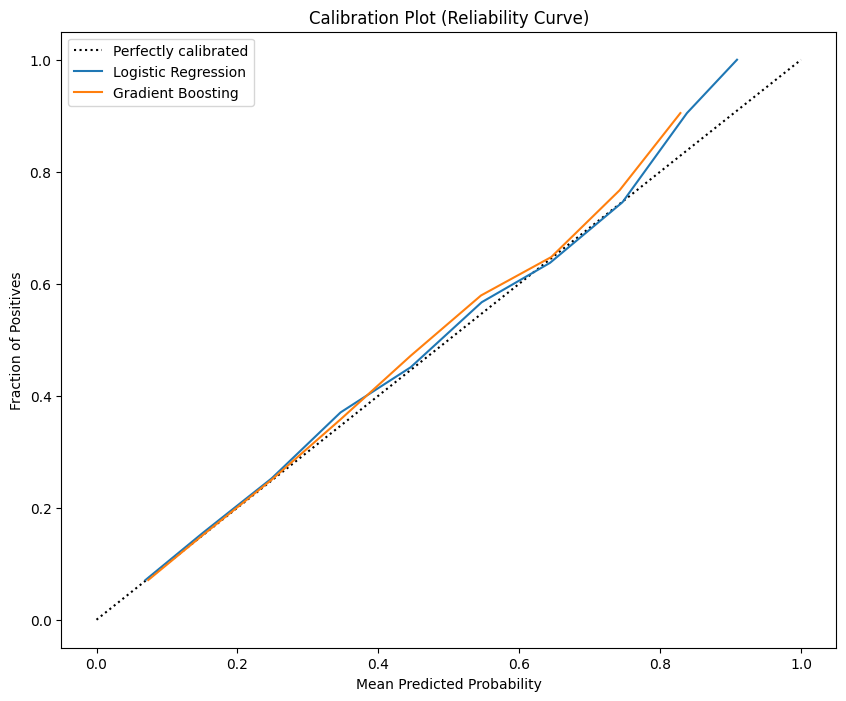

In [18]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def plot_calibration(model, label, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, label=label)

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k:', label="Perfectly calibrated")
plot_calibration(logreg_pipeline, "Logistic Regression", X_test, y_test)
plot_calibration(gb_pipeline, "Gradient Boosting", X_test, y_test)
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot (Reliability Curve)')
plt.legend()
plt.show()


In [20]:
# Placeholder values (replace with actual metrics)
logreg_accuracy, logreg_recall, logreg_precision, logreg_roc_auc = logreg_metrics
gb_accuracy, gb_recall, gb_precision, gb_roc_auc = gb_metrics

# Decision-making
if logreg_recall > gb_recall + 0.05 and logreg_roc_auc > gb_roc_auc + 0.05:  # Arbitrarily chosen threshold
    best_model = "Logistic Regression"
elif gb_recall > logreg_recall + 0.05 and gb_roc_auc > logreg_roc_auc + 0.05:
    best_model = "Gradient Boosting"
elif abs(logreg_recall - gb_recall) <= 0.05:  # If recall is similar
    if logreg_precision > gb_precision:
        best_model = "Logistic Regression"
    else:
        best_model = "Gradient Boosting"
else:
    # If no clear winner from above criteria, perhaps consider calibration or other factors
    best_model = "Needs Further Analysis"  # This could be based on calibration or business-specific criteria

print(f"The chosen model is: {best_model}")


The chosen model is: Gradient Boosting



## 2. Reccomendation System
(NOTE: this is similar to the Spotify recommendation activity we did for K-Nearest Neighbors)

<img src="https://drive.google.com/uc?export=view&id=1hFqrcLQM7Ibxu_KwvmJxG4pwSIx6598N" alt="Q" width = “400”/>


- Use your model to calculate the probability of churning for [these new customers](https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/streamingNEW.csv).

<br>

- Grab the 200 customers (rows) with the highest predicted probability of churning (hint: sort the dataset by predicted probability using [`.nlargest()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nlargest.html)). These are your "high-risk" customers.

<br>

- For each of your 200 high-risk customers, use [this customer Favorite Films Dataset](https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/streamingFILMS.csv) to find the 10 most similar users to your high-risk customer
    - fit a [`NearestNeighbors()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors) model on [this customer Favorite Films Dataset](https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/streamingFILMS.csv)
    - grab the 10 nearest neighbors for your 200 high-risk users using `.kneighbors()`
    - use only the `age`, `income`, and `meanhourswatched` variables to calculate nearest neighbors


<br>

- For each of your 200 high-risk customers, add the row numbers of the 10 similar users to a list, and add those as a column to your test set data frame. It should look like this (`.head(6)` of data shown as an example):




|gender|age      |income|monthssubbed|plan|meanhourswatched|competitorsub|numprofiles|cancelled|downgraded|bundle|kids|longestsession|topgenre|secondgenre|pred          |neighbors   |
|------|---------|------|------------|----|----------------|-------------|-----------|---------|----------|------|----|--------------|--------|-----------|--------------|----|
|woman |25.0     |73.51 |27          |B   |22.22           |1            |2          |1        |0         |1     |0   |263.62        |Action  |Drama      |0.83          |[ 93 374 186   5 430 352  82 267 295 387]|
|woman |26.0     |57.69 |6           |B   |22.3            |0            |3          |1        |0         |0     |0   |122.39        |Comedy  |Thriller   |0.82          |[317 328 376 307 248 209 202 416  11 445]|
|woman |69.0     |33.62 |4           |B   |22.9            |1            |3          |0        |0         |0     |0   |74.85         |Drama   |Comedy     |0.81          |[481 199 183 358 484 187 448 407 316 259]|
|woman |20.0     |52.05 |1           |P   |9.36            |1            |2          |1        |0         |0     |1   |113.91        |Thriller|ScienceFiction|0.78          |[381 342   8 194 307 216 370 363 197 416]|
|woman |25.0     |49.33 |29          |B   |9.9             |0            |1          |1        |0         |0     |0   |49.43         |Comedy  |Horror     |0.78          |[194 342   8 432 377 232 370 381 306 427]|
|nonbinary|63.0     |41.88 |29          |B   |12.22           |1            |2          |1        |0         |0     |0   |237.46        |Drama   |Thriller   |0.75          |[183 481  89 316 204 142 113 343 364 286]|


- Write this data (the original data + new column shown above) to a `.csv` file using `df.to_csv("myfile.csv", index=False)` where `df` is the data frame you'd like to save. NOTE: that if you're running this in Colab, you'll need to click on the Folder icon on the left and download `myfile.csv` to your computer.

- Then upload that `.csv` file to [this app](https://shinylive.io/py/app/#h=0&code=NobwRAdghgtgpmAXGKAHVA6VBPMAaMAYwHsIAXOcpMAMwCdiYACVKCAEygGcmBLGVMTpkmdOFHYB9QlwBueJgBEoZKADE6sOAB0I9Rky4ALXhGx8BQkQEF0CsRzh0FAV173xhMr1k69DZlYyIwAbXgAjC0FhJgAFFSNdXVMaXhC4JgBeOISACklJVPSCgEosKAcRAHombTAYYlleOC4MGVk63QamlqzRcSl23JS0uBLdGj7gOrU0mDqmAGpDMjphkqYaIT4+CFE2AHM4XIBGPBOTkoBdJMdJo7JJbubJVDF2LlyGAHcIFxguApni0FHtsicAAwlRC6JhwpgADz6wNaaWIhGAPz+AKuwBoVwwsigIRcLQwZGIYS4ZFy4z28KR2WAvAozC2dFExG+u0Rm22LLgzFMnO+N3pcMZTCpNK4cBpCJKdPh-TILjoEFyCOAEMQECudN0aFQkjcfTc5SOhRJvHYuVh8PNRhOdrAAGEXNTGE4mABZRrNJgAJTgJBg8A4Kl4pDqJTw9rh5oAEgAVH0AGRdAB5UAA+ZMmHhGpgwKAAa16bzg7F4XijEB47OL-t6niMTA93pgvAORhEYXLTHC3CrTFITG+RhUTGCGQa1MM-DSFXbsroPGFM6YnFUsr7vHLGF9ZYyXDVGWwxDVTDack2oyYk8LTBIJJge0IxPS7CYmfCOYgcDdkY4RCFwmZVH+06TiInpiE+0qjpMm4-Ls1aEL0jabpCTAARULQiABQEgWufIcq2W4qFALDEKYZAYOBuYxnG4rtrwGBGAATC6ADKcreBABxcEx8asRgpioC4jzYk4NYuhAdQKHUrpGMQxCykwABy-zhN6xCTMGobhtudZCfgTBEiSGTghCQLCuCQJQJKHE2SscCoH0lzMcq5riZJhSjC6RRwCcCm1GAACqqAhMQEhQRk7RMLM6RMAAmpeTCumIKhVjCZkwC4ITeFFcCZGoxKyrGIk+RAEmPFAtakJI4SSRSGp1AcxChXUADilBONlQYhowRmRqQpmVSxjprBN3lsZxLoGcNlDGWNwmTWxl5kLVkjblAhSaPALqngcRzUiZa0GvJdyGE4vhrL5ZAKJttUKLKXBcHW0IiewkzZFlta+BgABqxKkrkyiqBoWi0pdyoAMT9PV3i+EwcA0DQIYiI2QXtlFMXVgJIkAAL-cjcAYAAoujmPE6TPjk3AvjkMMNWSRgQWXN9aNMJItIwixyo-Rgu5fAM0hyCztXs6MzolNquJ1LtQSJGA+pKsq8LE89km08tTgYLt+3Q+rcIk54ZMYIzlA0g9GAdSbW7c8dp3eGNfMiYLkisu52RCw8tIe-CYiENIlJTA8TzNq87yfGxYhRfVxx1NMZmdGAZTxyEicujc+Bp2UXBRSytJ4CioJ9LbGqKqROzClI3sp4RPbEaZVxihr8KrNgiC1ALHdbl7gqYKYq40i5dTB6ZHghy+DvKnACLoagZD8-3Gv10PKeT3UVx9MHochIHcJiKq6q5BvAiXbchroH0tioLkRomu4N10HddJgAAvng4DQPA1AohvLIfARBSAUCoMgOoUAjgKTqKYUMOg871HEBAFSaouDfBUIQIwVZYFgCSjAEKSCCEcTwQQgAzGQuYAAWKhIQYAAFY6EwAAGzMIAOzMIABzMIAJzMMhJ0CADCWF4C4QwjAvD2HnAhOQjA1DpF1ApjAZq8kkEACFxAcldJecgdBsB4PChAYiai4xgGsJJIQcAACObhBR4LTKpUspgDhMEingn0gohDmD0kwAAUh6bw6EFD5kQWY5MZYXFMGTN2b0foXDkCgKYPBig6D0wALThHMNxFSxB+IHDwTk0wxBmoHCgJgvBros7vRrEwAAiqSSgQjqHkLwOwiR0iTjULMcpNg6ImDmDgCEB8vAABWxBHbDO4mwCkz4wGaClGpcysBUC8AYIWN6xSp51DTNwEQAT5w+jYCEnBeCADqtEnB4I0lRWQxBsAAQUKWMsOFbn3IAng7qFQ0nQLgD3awSh0T-GthUcwwpqEZUnMvJwhYOBMDYEwCmqzooHFJHgji3xSyAiYCcbAdAUkelLHggA0hUYZRyDFIMUM0N6-ioBGA5MKV0AAvJwEAuQsmZYUkMJ8CpSlNOo+qRgPTNIYXgXhHEMDkN4ecahGAWFcLMd1TQLhmWkDCXUaZZBsBllgB4uAco4pMG4qoNcPdPGGsDPcoMxAjhrjweohgjBtlukfFE5Q2Awg9jIHggA8pJD67ANVgGDNwUgUBwjJUTNgQQM4PrYusB4hFZyVJMAAJIQCZhQb8m4-TRiQTk9EpYmDWC8IUhJ7AuRqN0AwmyLCIQYC6XgFhcrqFis1SoNUnBzAaSAiIKcm54hZ3QucqsBNXHWHYE0dCPduKoHEMWjSXJRwcjUFYu6TBEyUm-GlK8sRPDBoAFqUBZCrJVLgKjjsRewdglKzE+l4DU8N+i4hqRZOdJBZyMjWDEEa3pAgP1mIpgiLQpi6ieIoJ1JB-qyDpL0uk9RxBb2IoRPOtJlAR1ILTVwLOHATmIN0OQ0RXD2GNvOBIk4iiwCxFINgiQUBmG1NLSYK24YfUFopC+-QzB1HCtUBAHuoSjzOIEohJgAByZMmhfAhHSCRAAZEeA4NZeBsC4OJhQiakGxHSMOQFEBxMiGTJebBvpg00bMIU0Y5AmApsfWhl1sxmBBsSvhBjSCH0xG4mpEQRSS1dnY2YxDIRK2uOikSIlSCl3MtZVuXgiVuwVGIAoNMBGIAcVaewuV7DREcVI6Iuo1gzDqo8apDgB04hrKSYUowOqYDYPi9YarSDExsG-L4sqFA8HBj2DkygBSkHEtIBeUs6SOp0FUcQSLPS1TeBdd51INW1TuaAyohJQiGHSN4bwjADCxUZcbYq8DphvxfPgHgxMThSwemLDM7gDrw14PzGIDI3FH0UBImOPNexdnljwbEFwQarzpRCOJ-gEkgfOCYLsvBabmWrMC0o1ZhBonEgyL40l6QPo3baxlaKwRiD-LM9WVQrs9hjk3GmywNTwhpBZD4-SjAZm1McSjYUVFAxoBtCEcwwHWAcCiUY+ma44D4YcRELJCg-SJOgHg6wJZyA8Bc8mJwpIQgpZaNct5DzRdMGecW6A5l3lpeoYqlhEiITdJ260uo+66AYy8BlNrNpspi6QREiApZIoYHCtxQpS0ORBo5GmZoOk8FA2fDgsgd1XHxZAiEYwGQID7ltZwSptqSXDQSe9rXevcOEBcCkxmaRUchGm3UZQEB0Jic3F+3BBbrMiDs4XGFQiMt4DbRgCEMqWFSo4mY6ZZSFnTIErAPVBbLzDNmd5gqDqnBHB5GoLOYYmlUrRkuNPSCrWlim1B+9CKKc4N9GVt3ZjYjdgOOYQVnu-ViFLCpWQ2BzD3-SOEJNj6xwudGRIXXMOkFVL02ZWnAYGR2JA2zFRIwwByzwA4hOCgP7zqA0jgG5DOSEBC1P1t1U1UDcWTzug+lJ14Hi3SRtQV1U3+wqEfUhSgA7DvR2V4AxjE12ToH0QwLABNWd1EyyVSkvBFxCBoHDycFIH3CgHEx4HUTWWCG7Vhyr3eAiGSiOWTwpCHBLWTxLDJwdQYBnDXAwB0KYF9T2C3R5yYGVV0XYDl3RhZB3HiyNAqFUDYz3wrwwDTQwBSkPG2GpT+U3WXWnzVCaBRm4HhT2AzSDXnUcBsx-Tm3Y10BOBlS4TkXIUVS4QbXIRtzAD8WIHGR5E3HYPtQ80kgvWGUnS7E0DJ2NXRGaG1Tl1kzgAOAYFuxwgpxAMEEMTIE4zYH+y9V7DEyqSrTYCgFYOM27VswCPzHQSkKpTWUxiiUDGwGDXYMIA-FmQB2YJryP2A0nECTl2gESQOjnzoDCD2E0X2OSTAGiLNzgJOEVUo3lR6TQHR0mG6lUm-C3XnUz2K1G3G0m3LzYI9FCI+jHF8WpS4B0jCDRj9XGR4GqPZSVwyFgCEBSzUie0oP10YBok0BdXlxkg-EOINXxXd0iVExiTtWPwSVUBOJ6RrHoxdSk0pB52+CeLn3nC3QoGGTHG4mcW-CtW+GaUywbREQ717w4hlU1WaAOAUEUCuSpRokJP4F10UGlNcSBl4FYHej6I8RtHYGSl8VzS9HIDwQAA0awXBxMp9iA0NC8NEElywORiCPCpQ5RmVwFUcYEJizpyAJkx8AJ0I8SB9t1mgodQlClnlmVnEdDDwuBgzQzdCIyoAQz4tqQksOoS0JtKI5dnkyBTxnEGiKJ3oHDXUIgbQ4Bnkmx2UylTVeANt+92FSNyExUJFNsgMmgg0q9VNdgmgPpI1g0ypK1btRk4ArxDUuwAI1R-dzB3QhwFBfUjx8oKBjUIgZI+lKkTBacg1iyGhSzKI0k8EKZ2Vyw9h2VI9Ik0k9daIqJxNj0DMmBiCjkSwLxDA2tbVuAqJiC01nFJwBkaILwKykEdyptKBsy6NnFjyRNsDzzKBxMrzpyoA7yuAHyylYLILXzeB3yvyvzutCzqCkRI02AZANcXU-QtDYVvxlAXBvVW8oshASxhlWdg15SDMRBXRPwzNEpNBPdmghEW1m04CGF+8JEWEECwBLtf1rAaAPsnsXlGxrBCpZ1fCfBiQxMqJEx-gEU501kWR1Sn0BNjVWBMNwkCwoBZB1lpx0oSxnk0lvBJy-US8xw01dLNUF4CjEUZAdwGcjUjkC8VEVs6hENsB0kkCERYN5ShBty1swNzFVg0AJBESG90gbNm8HMNtMsuF5UzcG1tsB9QxWA1wvKQ1hdWCIi4g3I0Me4l0KAGwAh4U6UYtjVZK7kfTEDKL5KaKqj0haiJkSwGi9hVgzTmikF5cSwYtiR4tVRWj4sMhONDcuBKQ8z1FookNViMhNE9krLhkyovAhAe5NETA4Va9lwxwVdmD4TolTl3ckNoLhieBRi1xxjVs0hsBRDoc9klBsoOLFV2kMAOIxUUj5V20wAjkP89gv8f8UscqM0thhjciB9SxXKEUf06MBIhlPlWKXNPFyAQw0AKRLKkFdlmzqw4BwgEzQhxdUBVxp1g1ekPpRNNwKZ2AXSzEI9bUAJBwGBOAcI5RrliAYsMhqwEsh9ktodg0htmBvBZMhxnk29iM4Css2lJUSMzFeEIRClVAxzdMwrz82A5QqJYzmU1QGAFA01D4+rIrgghwIxZBAcLSzEv1kzxqj9-1VlVoqU0lRKXFPk8k4Bv9A8qI0xVUsazFfU0llNoAplsEglvjUtWiYUxNeI34aw5jVAFiVAJlliORtS1iEQNjqQNtpF2EG12FMte9TcgsnUAQ-UQt00GB6xCyXUwaJkzkKgXVuoqRYKOA8yJT1R-SGx+yERCk2sPxqQsckSMhDT6kXAe4v15w06MgpN6osVIL4gYgOIe5gw3wZl5t+Mr0uDd1eD+CC0edObn9Iqwh0Kg84g0kg0hEiM8AeLdtWlqE4CWFhSwAYl4BxxT1NJZiIAPk+qXAaBwg6AXBsFxTJSB9G8ndZNWClTawYBWDUkMkuDC08lXbTqKRSBXFmpJxzBk8chCAWQqIfQMBNNCYNFHIPtWCU0pxsNEoEkzAAB+BxB02cznbBOU9ikh1o9IEwitHuWA567AHgQ-DIZRVZMQB6mml03QIulhKWxVDiSVTi7yig46osjIIdXgWY65QUNUeLYlC8YwNZCZchHuHch4Y6NS-7AqKav27ywBxdIZKavYWIOCa2LgHuEPF2qmu26KF5XxH0fhj7cwX1dGG1QgYtVJf4IcgbILfCLwlk0cXrDkm1bkgtTtOgIY3tb1eFEQQdYkROKzfKYdAB+YQbA1NDBanILO7G+g+4x65g7AVgm5I3HXJ5F5Q3O5HXIRGIsRC484Gss4OoAO-mnTSiKXVMn8j4JoaoypMlJZRihMgCTgYx5PA4Dq3xKibzOgb0kB8DFoWChfDQAwb7IcdSKS1AScB1WxzSexscJxloFxtx+g-JP9bx4tXx-xpwQJ4Jq1UJpQIpyJ85ZdXHJfFqbZv6ioBIfNMxSdDGlQZldRnKzEtJbE1KLRECKbJ7b4IZFGaXYIUyXQfi5tOVSjZtCRLhJ+nTcQdSOiwzaJEzNsTxaQ5RtZEtAmjDYNQVYwbArsQce5CQZlEwHVVQFJUGB1bgXsKiblkCHVdgfl+FoVlrYkSYN7akUFwMDClwLC-PbFVLF1JSsMFxWnNJmrItEtMtEh480JAcNRjR04iAahGyWsyRfbSVbpTVCJ70bzaAVQTTP1LJUsdlJmdlWYyPQHPM31AmQwScesPgIA7VLgQVj6FJaawPDIVgIfKUKiSofoxFQ2oLXTbBf3VBCZFzK1dSYg7CIrJZCUwQR9axiKdycKVij0AAQj2IOKYCOIOJJU0CDTIGZSnENzeG4B3yaCLwSEHHMAlI+gOC0pTScFUfBeqOGVQP2I+DM3ZttdzuvobU+rwCIw+t+sYuwSEHWTl3gCRZEJ4G4kxblBwVsMEyPyORfXP1CfZG-BNW8TIRKMIP8SD2-LMSFunDSBCDFpyrVYEmUxEFJSmuYLKT9UkjgxoAQyQ151QxkjZYELSdIv5oplzbqDTQqENxAhAlweinqrAAya6LWeOsvBbvfcICylLr6vXNcXzGaF8DxYgHITOBYV7xlTgNgLMSEuux4AVx3EKW+BcVMAgo3CP3iEuToAeqtUYCezyT5VCNWBcD5DICHDw+o0pgwG6yGW4AvDCrgY8aie8txN9A9EIEHp-r-oAaAaUFBYlNinZKtLISBU44YTOHYRdeIy7yo19XLrTUrsDU1x-IEG1Q7bcBCxcVYOl2-H4GNR3zoAdrCuVW4B4B-UoGzcDKQSMRIAgFsXnfYFYN4hUTSC07TTTUKR0sFHaK33Vc1Zwu1ci7MWDGqVM-+2lJEFmF8GaWkQVQ+tEXIUlXIVdefpwVEava9GCCiWsBAkkkqu83i9Bc9dTRLbUgyHLYhBUKrbchomxV9Qe3VHTT2A0ANUrRgAfde041cp0WigAmGVSWPE0ZQLQPK+Uae2FUcEZT2G6hcB1VlyQQCXdOxXZzMHHGgqoWcwyDUDczPaxMveNRvZnHveUaPGfZrFLDfeNQe+5Sq5JHTTq6pRwpqdr2u+aTN0Lv70hHkSOwiir1IFK-eAGIku2CkpXhqtjosgUs3WUt6xEfUqiz7QF-zFo9x24gY-ECY-vS7V0kmCu+eJWValYLKi4Fwa9aiRuVPmDQfRYeGT8Q8XQS3C04+liuCQFpdRgwi5SScJcLcI5A8J7i3W5B8L59hNhQu5CL1nCOEBz20wPQjWSmJRcRu9FTaTzrvuyym+heXlhfhf1QaBfV8QOSCV1wK4pLeFU0caEG0haALzITuy4BLB4Gan2PVW1eirMVSyOAjFHGiVGFFZvRqLHyM7DWgE7M3RjTyRwXjR9cK4baba4Fbfdz+9PuFCB5B5ypeK17yQLdteoX71Nw+ukTkXYX6b+vDWh0fSoinfQgF1E3WbJM2eHH1UgyRP41qQshdX3Ve1qwdUsg7bWW++z81VNSefcQ8zK06JEGFBAwnA65RHGAHD5lI9cSSaGnmXcoRpf08nVOkqxUjCBHMsAOnFRBcz8YdwCgIxO5kIypVds0iIUvKlSIZomAymIphYBuzsovAGQQ1MV1PBdh8ojKGdv+1tx9cEsg3H8l-SjDH5mCNYdVD3CzjFgPQlJNmgcDCCjgFiJgBxE9XYIcASUk4OcDIPJ50Bi01gBvv2h2pydsuUSKerS02Zthek0KDkNIh+4pM0QAPI1BchCxD0mAI9BpOPRib6CZ6oTHgMQQXoiAl6g0Veorn+z6lYcZAB6lRHEJGtl+-ec3FKmG5d5fqESFVkamvbiAyA4-MxBmhWbLgji6Q5PHsBLBJJ6EYHPKuYIHwqR7uViRLn-3F6ADgBYCTRswJ0Z6MTAdRIxoigRoZlSK5jd3AGAcFj1bMzgpCEflcFz0PBthJgM0M5xpBbeEVEGnLmaB7BoBZCZAsfjYw8BJOwQa9HjSdzukocWmXQHlmj6SJOkHEZKgVkErEg1CryHlgwCaBsUusWGQjlRGI7lEyO5aMpuITIANZLyPoWzslEYrkdfUd0bwOdg8wVBXEKUWMrTScBmEC0-OINAiCJydYZuD1CJOkBL49kSwfZAciICHL9lyOWXd6DbWgAVcGuCuX7lOBxrmADmzAfdCJgGw1oZU7CZKrwlywCdUis1VsOLg4YI88hZ4aksiTLCokqs1JPJGVnQYuBMGOEeLPEFwbYECGRDSziGiSQQBxSaSGLOkAUBAsM8a+IkJwFPB4J0i2AavB+xYIlp-sMkBPDyC0go0kMQyZBlbXwhsptyTZDDK2VMDtk5CJuekclROBioW0kiE4Q+kKg2UnwRSHTtAkUFwl9GFzfRO6jqplgHU3YUevhDrDlDZM91HgOfhCC1F+AxrdAFEk8EDEo2c9RsKVW2ryitUQyMILcPpqqY+yC4QGkmPZT-Y0kRIJhvjA2z0idsu7UjOwnJa6YqWpAGlsZkAb0tg0ESWnANFpzf4wqSKWpMiJqaY4WgvAHHHCh6IE4icniEnKNHJxdUj8VOQQDTjpwxdfEVqMTizkaAZB2cQYLnJqVQ4wjBcuBGFFnxOo9I3UnjIRhCPDyzCcqNyUJrOQUJ7BqCkwINMwDnRWAE4fbYBuRxpKpj6SSGSpOkDNIqBNA6pb1OYBfotA7uAtMpIQFcqlsqIC9LFJUhPS4NrYOHQ2oRjODUI5U3ePdpKmrJ5tjwD1cHg1D2CcItREwm2r8zl62i6gxKOAAynpIsNhWyeIZA9TnQVBvi5+E6FfjYDfEjkLgIkI+niikB2AbgKsXUHd7GUO2sJY-EGmGS5AAUJwDiATzchxBcM4wPqllTIBsYmAzkNhNBi17LYGiQkpBEAJIig5giaWXdvxUbRnA5ERdGYKYHkprdJIdYPUdAh-zFkgBqubBqSmCA5UVcVEVYW2BiTow2AtBHful22q5AxgnyS9LMJhIsBJwYgblCSFUTyjG2aAlVmFRsGnY1k5ox4t-ShbntKSewFKKiycSqcteeArjv3iZE3F92K-AfL8UoD-FyckwIEiCWaC71-aOkPGlXmDRN1H0dHPMilDuRf0MgSBSOlDgMrogXq0GJmr4nCg10ghT4UIVCLMSUcRA1HSXh6Gl6y9YALqRiuAmDRppbMj6ellfms710NkGUbdPCh4Db1N0WiUAfmCnBsdRM1teUp0x7y95iWNZX6rVOML1SeAjU0cVGyTpPSZuAbKoMpDZSNBPkF6NJlEhpq3oLGkOUcFp1Bzg5AcOI6YQ53-rDjIJ6pG9FqX6EZA-QbGUqS4HKkScpOl5WTguwU5KdVIxTAfBvSiRb0eCsoPgs0lEQiJG0Y3XvNxzPx4o0BLmYVCWFMC-4cq4fd4Tgl6yXh3ImEI-DPj05fDSw8rcJG5hsm+JjMzAPxPVBKT1MihdQAJCdDkxiZ-UweCQC7I-74JFhnMlxm-TWGkyAwjFLYUPwHyeomg2bNJPABUTHkcKQgKAPQ2BFZxkeF7MSejzvbCBMJT7cwC+zx5CB32hPPqhGGiiiC0s5CGyEkQwBcJFU99XbFN1ax8FMEhcvrtcnF76D5S8oqTB9OgTJ5HRJebiGqFz6yhWCOiZsloFnT8BIWGks0gv31mkiRA5IligYGpE8SwWU1BrJUzPxOAHcq8vaWTkgbEgd8SkkQAAw9A6xbWCRMRHx0OFSpD2K3XHIGHWxIJd0omXqOQHSDhhSsyeUrilmVLppusJSaTjwCQJ7y6gu6TiaVRAUaJHszHFHjighBEI82TxcpktSgXUYaw+vcqgYA5yMxKQoU+eWAF2RwpfEjiKbNpO2pQjdhdaC3K0hrnyopuuyecPIIungYKC1sScCEFnSk4amyiefBhgylBMMYaSASBrw+lRJGwzVS0tGNEyKBYx3xXtBAEyLPJuWNADsGFTTSnTKq50wxBouoK35uwQUkOr2Fx6Z5hawHUDhLTESkYpEMBKAr9V9QQkpQsVJZC5jhJQ5HET05cDSR5koiKKsASFM6mho9w7cDjeSmDUsgLT8KbAZUgVC3FWYVmFaBIQamPz1gxK0IxOCWkUlZxOypotGAakFY75L+cAPMlqlPCjJhQ0ApgDUs4BsDzEdAGAK5X0JpZa0bSOGd0lzofUBK1gHgG9J+nH5rhE6O9t+F9SJ0xpn4cwG9OmTchHU004wmEAEC0pfES1SSBlK3Sv0TZi1AqOkAzJRyNJirdua+log1ZykxgWSYNGAnLxkxrs11IcAyA-86+UAFQPEPSI1E1IWcdsiw1Rh8FVA6uYGaALSElgOQmQ0gjkLeVzAcqa3NELYgymhoolPfaNLGgH61sTR5PN8CODTSTAYF1LKIhABYSZY6JoiLpJIiZ7hNlMgrV5MYGWTMoGg-Lf8rKzuSgCIMFSlJKpjT6TAQhsUHGkrVsKC5UALVGonUQ6rsouqTRNukX2tigLacBmCBfhCTaso9gxKfsAmn9x8pp8k+Z-idiERbtH6B7DvA-SZ5mytJZsjopSzPCVZZM6pLOG1TEw+Uo0gEb1Nin9mItWpKLCoGi2+JqAAAVB+2FUFohkE04pfWHJi6FGwOiTBGk3wrLcKQLgHfJbV4mlMleRqeINgrIGn0ruMAC+p+iFSyg0O8c62NXLFTVlds5wF1kBkcnGdHYyyMpKokrQuoJSRQejMJJfiG8TACgHrEnSYCKYjkPdaDK0QmQQCAsZ5fQobgPLPIxaxACCheC3IKtr5DqHVFnGwIJkdUhSH5RkSYCHpeArKUsJhNDSVjXKm4JUsIAKLqk4UZ2A3j5g7ZCAokqBBXFkSPwrt0CDyoxJsAbFbhxMVUmnmIjSr7Y5EvHcJF0PiyODehk9dmdEk0BuD56IwsYXkN1bKlVkGQRMEBHblJtasakZrJ10FCCgdIEi1xEul8AqJQWuybwKqBczHoGAJKPQVBrQ22qC0k4CZCHj2At1I28WMIFp35bJrt5EyQ1A+impG4bM-5IcBQGMV5ESIqkhcFb1-wdcrOdABfMKCXywA-5y-OtA-VaS94uE-Szsg9S3Qdh00qMl7EqIeXh9RM+ghjXp2TDxo0M8WGABQFpyBEtO4LbBL4AKj41mx1hTyqO3J7xZsEHoUsctl+4vYxMx02BjKr1J9UYg+6dAE4BKru18FzAKiI7Oqqjy+ewVPqs92-QMc1IOXQJJoDCA5VrauXP9EoIy4upZqGC-QVgsJV7ZxUcifvJKgYRTdQk3iMTMGCZh00lEPAiZH6H4HFdPCwg-KB9A-DiDJB6IBrEmzOhPZNAqQEgAoFw4MM+2TDIVKw0WnI0OZJaj8MvH5qnd3crFLgPLljKkAic380+g0ms7pE1QAEDKZ4lVL7MKqRzPTKc3OanUhiwyq6lwBup1AYkw9MDT0InrXSoNgw9wTkEXrL1BQ2xDMtnRJbNyZE6-WaVWFmF2U0ipJNSAoCh7mAMNSCWtPt3akN1Hq2S+9F4nQwCNJg9dcjtCxLBnpCsrdI3Lhh7JDhxkJfZCfiWLSSVpKvPPwvJWo56sVKIvUAT0V+BnsBq-bSQSNW8CoxjK6oKiFNWigbY-OjI-jjZEQLa5HkkAg3OrvRmhblWH2ARnsG+yPU-sWGPYBQP+BUCeANA2cvQLGj-B+AV4bsEPI8zxrLwSa2HPDlF5n5-+3RaKL8D6L5VLEYgWxM0DFmYENa2BbWrrX5oG0MWEyD1CsPfoBJQSoAqSZfg7ayTmkMqTbF3j8lAaqMV0iXmgjo7GoHp8vQrLwHSRlRvivqBIKwXCgysgpwgCVqyg0oXYnADgKyWwxJ3dVBAlYprsNNboi6SGoTUZP8FWTENUhRIQHgwGZRmBZltXDirXN7w8VK11uJ+nEMqLY1GGGQZhjgnFLd7NUkZNiNGWP1hlDAx+lYImQmQ-oxNCUhlBksFQTYQwpIVxiWg7bDo9yI4HRPADJmdD-to9JwZBqNSg64NEOnwdDpdTEp9EPOOfnkjpREg58VeIwBVwAiooGA2CcWsCKE0CaP8wmkQKJuygSbCMw3CRPfTaTyIpu0Bn-H2wHZUQh2EZf0NM2PaHUXUFMUsOwACAvwyePSedv-SXFh63QADPNWYmUBqCS0mgwIjmh0E1ILNIOoQKZmMEfYmAZg-2UUnZSlJykOVSKDXCy4E0NCC6FwO5AISJduF5AXhfwoGi+IhFimkRRxS03W5FUN9dvDMG87GEGARh8KeQD7LYoJS3KWXqqGGTWgM9AW3kY2Msm2EbJdkhhg33axQafKUho1BTGgRqiHlTWZWKbU4Dm1VJGhUWWwcma89x5T4xaflNGl1qzmeEdsW0mSo6aO8UBKbhTXdTQV-+Xc-spi3IGV1mysOHDG1nyrPJhqo0lQQPjLBOSDyDjPMjRkD7JRiQxzVYLCS1LokCobgdUnEFJDCAJkarEgEiVfrJSP6lAJqVZ2XA6JSS+idPKsgUC1ighSSIEYRhsiQhSM-JZyFKiZ7X5XErx3I4RXP36EvCRhLhgoJIZt8ykJYD4zN1aC6FvjhhcwH8c4W5Ug0iXOUByrB4RTVyVEaKQA1ikJAcqT7CFmFR0ONg9D+FDUmzLcq6lCVwGlrfXMSIOKXF6Mc5GqQLQvcpkKkb4KwXr7LRMF1qXHNTRSPFGk0OBkQIJomTrSCDewMTeIF43sEy89efebJnix4yPooSpDLxtw5uQo2IgHyt1mgRHBkMRWACXCk5wnQqw5gIrH-vFntbuMHbPjGwHzkElXEviSTNJgrFR1+10CFTGpg0yYrJGoiYlU-JgKTdEdSkapKNsTGr4zEGfOOnrRzYeJXdiay8NuV618CkWggjNiING1UQ0DE26QU0sYoCAcG9BGsHaul3hRgT-+ZcoWTXKkBHy5ZWjfiMEaaQduRy6jH2OtUZi9Ol2AQPYWaRVlC63SXzvXKoxsLfMG9JsXczfjJKOM51KpCgi1zwBydc5MKsZm0klowgvgFIUpF4WxVutbBFQDqg0XwdgdRqcYWFVHmvCWQHwiCl8K14-CKgnKt0rMk9IhhJSNaVpA3MkR7siW2-X1CXjWqcZNq-Ek7NYL2p7ADqDAAMs+J2Q76rxLDA-bRUZh0YrZSkIZJ5q3H5zRBKOXxPulnLGZfgieOFLjiEwpo8yOiPuWpA-B6jw0bBhZJtAWS+AuU2mFmt2D9ngW2C2CYdF0VPpppqw7tUzR4Q2x1pe80tbjrtiZ43JK01YUsOmVVBy5BlF1EZYt3GV6EpldYGZemmNTlIO26GB4ispJq9B1l4prfeenymiZSZd2vtGhNlJv6hM9feqLhOw3g7CJLWReSQGXmuTKQiecIEGwyA75CoU1eCboJRyXbQzijTkdCZ4YnA+GBupIwBlm7Xotz6RIwAYUoAvouTu4z3L5Rox5ksuqqErLawVTX1uxPHOiVRiy6OAzMaNHbZjT0JIlwj4SRgA9QuQYw0ySSacIMaaXsFZyviVAv90MQyFIwJ-OFAMtlAqIjC+g2IOkgUTHUK0TgePDYDWQJwDjbBNA2qHRBGAsD1YqALWMpqOw3SeZTnEGjuQW9Wo8KfqEXgKPIjIsNaGyPnUbSr84C1CE4QDndIDJ9gG6vqpwET59tk+2mdHc9c0CvWFeaTNNSr03Rq9SArBF9ngqyaBEUMZZ9QvmtB7hI9kGU9gi7Cc4HrjC51UJEhIvE7iMgzkNYa6GthqgMpgqMZFp0FTfA2dZ+TQMynYDJ5i0cgQVragmRpRbDoPOkdfTgIyo5ENEzVL4FmSzmKQlSYQ3MUpDwrgeY7NYVwSnZO7x6M3BdoVvSDLsvuPAC1KALEM4SHqYi9JHZlnJfob0W86wBJbwhlgzKC6M2+CSWRQlPFsJVPgiQxIVzaOh+8xANWr62SIQHt-JkkoY7-BKy19IDa0gbRcJt+P6LTi6qgDpJnk7pa7NmWMCPkmlS+ZUv9jVldgNZylbWfTKtqFkS0OGUpnLl-qMznO7dbo2QweXiTq81gfJaH2DThnvSZE0VqPvH1bzVFDfbMuMj3Kk8yeNaaRHtnrlnAOIysoTl6Bribh1E+yuUBqv-w03zAcisxGtNIBM0tppd3aYsXMzAcuQqQb1AKqlMwnrAEVVgE2v+x59Na8KGLNHv1rmyrEx1BFGVAaAio18WvWVdwOUPMZgOkXfFqIn86+S8ADaFhFRjBleta+hWFqciwhs8iv2GSq7sgYVyQM8GcWCwqR11y4CSUqaxAemuWr-77BAOoAwec3CgHhhMQBDRMLlXgKrm2Cse57m9C2kAwByx0v+QiRbnnsLQFSCFkwmzVSQKhI4OaL5zocFphSRk8amZNu5JGPo0jKgooMXBLppgdRWgM2DaKLsZwug5cP9A3Dg0x2xXHWoOpq48KI50muOaVQYLZg3qCrmftP2xkoy4ZS-QmQYBJlb9YzUBrFSbwFgEqxCWMqMFAFLoQlykMJd3EKprhw0wyGJaSDiXbka1wglzESAbUVpoqhGYjDtiZHnAvRJw4RjFzHtpBx0FXSfOap1XaZ173wTe72FkGHIEUb8ngZPrp3LZ2Ab2oToqznIqtyOEpbUdwF43DMAIpOdM3LrLBXCPp7T-VIamyKmo39atm1OYCtR2pm16+LOJvl2FvVlZRAnbA2SUjT3oc5485JMW-CyJEARGdvbJgQzWwa4Kplica0yKtZoAaqGq+BnyLyUiiVWUot5hIkGWlIFPL8Hvw45uM+IUdC05TiroiHCs2W01usny3UhCtZBDRFnFiwB0nl0hKam+FbJUNHi81RsLui2KcBK5H0DpTZHuuNomFO7VrZP29DT9ge9JkDRc7+qk7XKtd3k-iXHGzlJxA+23GqYMCjzwgYKjO2XcBXlgYTui4Ia-zCHRMjjuiLuMPObK4MqIrox9O6L1Ho7Ieep7HbD1tYD3ObXeVpAwmSqr6uFEZfqL87dDPORwIeN5wLW2lJajUGae3gguQzkLUUvyPUekmJR-T6wIjGy6wUyE43Eoy+NTXPd0SuJv5ZAX+UFbR1nQ67i2vTsSjPCIS2isgijbTJ3WCEbXdrnRA66qw4ThHwiH0XIiuJyoVZFeAyjaCuYJ4xw+r0cdJjyEn1xTrXKvO12bWO9XCK6JQM0Dd7eEJk6Wvwt72hueTQizZGwIH0zVlI4WR4fmtYDotBYkkY+jPZTbn6PTlDsQbiFpnpqCF6bqPUIZIXld6Ufg7qKtChN7DmXZzmE6yzhI612WCJnHSbmIjlT8lmFeVpSLNkfQeJ3mHIb+f1CBX+yEXdNgUFQWOLmYD5mMRFLMUboVpVNVEOKdU8UYWscEVrIaja064uJIOTAaDiezg4FoWxtOWcobjSiw1ZQ04iZm-ef4cPp+Jmy+p-bPfdITg0jH6iTtT40oxMlO+rm1gXjwiEgTgJEWjj8s1IArjSMKivXw0yRRMxGrj+R3EKuJLtZ0MGw8pfeKEMgvSD9x0RuzoYIAYZAVYH1EwvLft+lQyksgTW3YzK76OtjeQRSldbs1aIlWKkhD+T6eEiXhNv3LuNc1auCnkZsAqqEK7kJIOG9bKSnv1UpNAdKQ6mKmYnBDDNGdhkH-pnU2abK5aXWFnQNcZhWk+m4FsXDZko7lEVGPw6cT2cz8BnELY-u9Uv6MJ7+2arPT6jfgf9Rp2HSv3rn95yEYjp+u0rC3UlENE+2lmGDBTAWj8yqJISWmZZ+N6nGUlUxUZswamP5aoO6WIH7YAMSyeZVLKJi7AIphUWuX8RzLYAATf6jsECdEC2irrmUzMwrgdHez+uStv6TcPbUAw2M3SriGDO2qlw1gu1g0QB32qPCDqZn1RyRK0gHtd4puMGcpkedU4wB6r1Tf+d7X34udH7x-VxKfySTn9ZQpIwB7qzaxOfhkl2ELJQEW3ayUkztfJKVhUkVZz8mgJpdLn+8IVD+y0KJKD7WT905iO3jkPD-9exAAhtrBhCq7on09dsJwhPqTjhb-WK8Xm0TLMGMCd9kVUaPvnGgxWzvjsqE5vju6x57vbLCFI9zEfZM1bOT2goRjyfIbZ2Bl6QNyJG5ZDRvqNeZHci-YazVFCT9quousvuTOq+0bq5ix4VpSOyGUPIFlPjNWF0XCMYqXhIyP7sNpZEohwlHLmNrAQ2sBlC2kmkU+JQeC4lGl4F7GT0uwA1KUFAL0FTfh+Vrk3BfwHIbLgjRd2nzPBI3ceZdmvydecwGe0nMQgFRjbMRhX2yMG0LScWWfOlO-ajDaGGNXADXNsEv+Qqop0Obazbl1kWnCSIseMK7m7pbQyH0nRJo3uYq+z+KuRShaO2q50hACNohJ+pH-ZniNJFgckbSIuE2WURBZ-rkb7ikGXmpuFrLshqXOGMcNefqjVchL0NdLKiYEgHxYigSDBoA9hCy2pFkEWd-A4zrXf44Tj1HZyEB7ONmI2CHOLnhpId6lAF3rBoP4pbLzeX9PChLewEtpRgS63pt4ZUlAFgwVAormuDOIGQEARQwEAKyjMAaqqprzsxTBv7NoaVN6ZyIbvtWLYE1YAg6jAOAgjYDM35kjAbUNCgBa7UqdMBYd6R1GoZH8mAZsxcqEZAGD4BrFEQGwe7rmQFLkTOIbiKAgOG1apM6TOLwDoOgsOjk0lJDqJbEh0g8QmaGNp2SVa26O-7hYcYq46JIZfAESV82WjXw10vbvFhHIA7s77pYOdBRg94O7FRhfCqoNc7sAxRFuJlEDzsjamoqJHTbQUVEDvi-6X1s1InaAEDwDOQnth5gl4zyiWZI680qjpSUrVGKrpmjRD1R5kADpjJncQRJdwvYN3JhIZ+3RNNQvcvzO9wKs+QgRAPCQgCo7OI6kmABZW5zh0rc26+s2hSoqRPPYbSVzNtLqidyKvas6OVORpa+VGrG4T+cVM47T+AzEzS9yfDNMwvSdJiwF-UiaghZgAHLOKzFgceLywysArPY51AarLQYcgOkEARBeZgD1JCkcOg3LnAysr9R8S+skYaJGl5qajfgChKya44lCk4icB-xgBzDYU2GNhCAXxAAFABWMNsCgBYUj+RFqspOQDik92INiJYD-vMLk8FAKwQpQg3rBTDeFQFpzrkeZBihYoCgLigNOIrLfJVkNRsR58UAlMmD0kEViHJtgyehUSYckJOJieSJdk4Dg2uGJrTYEk1F07+gnLEcEx+kWqALcQ+9MyiH0rAMfSDYSSJwB7AX5pgjZkxEIBB+odyLdjRQ5vBD5i8aihMgaKj-vI7B8aSOaLCglohzLWiBxLSJ2sxGHyT8cFxFRgNItEIVrZsf+GYhlQsppDIlytXtSAZSsQMWAtAyUPOhhA2JF1JkWWGB+AAMPAAT7A+uRs6jbksIWxgIhLqOMGUaGQDr4mKQdMFKh0ligq6f21ITASy0qROBwnQLILB5hosHDlQ5m7kFKL5mhAJ+L0B9BPNpMBOBDlRLSqpK3RF4rapvidcWpkaYqEeppyQ9hOphwCIqiosqJ7qzKKkYai8oonZBquGvoznC1gJOCIGTGmpTXy2ZM2S7guorfLUBZHuWpb8c7lhwdQwbpUjXu82LLzJMNfjvanWHEqVqpI3EuU7mI-Ri1b1gQxj1BPE4nu+6gknyH1AiAWVMlDsA4mEVhcOB-Dm410G0ov6bMy-sxY5EB5t5jwAC3JIrmCkjN0hyM8iK0jXEXCMz6zCeuBeD7mXsleASk9YIeqXel6Ikabgn8q4gh4Y0ATyfsE-BUrcqg0F1q0UNKL0C2+Vgg77qgHKH2wzC-5KiG4avWAbLyivqHcpdggbgPzPIOqMAS-I1YOz5CGsZDParOCCm-5hYjQGYE58PyPnxFMOkI5KX0EQv5Lioh2DX6KeriMp7P0UAOjDmAwyohjqgz-OyJIKF7HsDAYLfFFj0odxKnq2ecEPZ4EKjEcQpgBglEPCdmYLrPSbCPXMCIlEKkMeZDIPMgkiWh91tuyNoYqGvzUIT9Ecj8Y-bAp6wR83KWL16I-GwAtsmcp6oE6E2J1L4knuN7i+4ReFWA3mE-FNZWCM-MS68Sy0vExGoS6BPKYqPSMs6z27AsgZtqt8k4YLOPdlAQnCZUHCwHK+TCyBpIMAlfYAOiUHCT32+8onDV2sHhHwqcSIXIZGoVmnYLdCODuUz4O4OiIAnAy9JsRZa6qAC55aJaAVpDUOVJ2zCgN0QuZ8BaSNSD38X7o7gUwv7hxRnACtFEL5W8qJZ4RUCNCWgVK9YMaw-MpaKAIPuv4WSjc0gEQjTCCygO2QjmuDLRzpoJYKdBJoT6vp4kipZp+D9Y8dL8jAutjD3BfIaEnexzGz6njYQgBNkTanGpugv4ZQS-lS774-Jr6B4GwpqjCimRBi04X4Mkjfi3yw3HcY1GqRNQa9s-bPUEsA6JCOxNKSBJ9yrsk8mNBP2QGD34sAy2KeAD+IxrBTD+n6GOiLcU6HHQReC6PWbcg2wGuhiAG6IYQ7oPBIVR5MUpCqpSB+4JPYUkH4NoEpM2qLqiCGeOl6okQ5GqCx7ettBJ7laH6NET0icqDcG92DIq8rsKw5mFH8QofiORohW8hDBby-WvNyEEFjPm51sswMHRlEzntCEOOG6JoiyYfiiwansNsf+Rqq9sUPyEY3SDprCWMBMlRZu25iySViwaMkZo+eRN4GFEvgbc51gAQRUSZ+WUqYA5SFkt7pWq8AsBx+ougW4jzY7KFNipeVnMgYVcYDFP6Q0FeHCEfQ+DCdiXURobai+OQmMGAfAiVM2iSoEIFcTpuAlA6F6IuTJnb4cX9OiBssZ9BkSYwrBE8EBa7kLjhvBpEZ8EPKY9h3Rvi7huPrh4o4AF7M0wXm051hGAg2EqYqRsg7aYPur4jC62xPlzQRI0lXQAkE0o+hTSYJBPzgypYr0KAosONPruGnNPPqd2l9Gbj1xb1CyLiypkqWiAuRqNZFB4S2FTYNULSk1SKRroVlDFoAdIzp5B5kTQCWRARNZFhU4hAJDEAzbFjzykHlCCg0x96ABbXqStLRGiG2QUBz-kqKFsSVOb2iI4d4pGENJ08dfNUyME3yExbBoRXKzxrGVYM66z0Y+gBgPh1OvShBkMNHsBw0UbFw5JoqwFyrQQpvIDZoOwNq1jRcInv7JC0+UMnjYKcDL4CZI2SLkhtxUjpkw3SxevdKMcnHHIziocBFv6JOJAq8osMH4SUgKSWZJOpwAc+tBTJ4kkXcjkkKnrVE8g9UWsHcQ-Nu1T4QbdAqRi+cpI0lKkKpC3Q5U4bMKBXK0bHurTg-DAmxNK-VNrRDU04C1BjUMupNTTUy2iLKgxZSKYAt+vSADGmRWqLubj4PeiARi2-GJfQ9KUtGSohx2-D5RzmQAsnjW8ahg9xeRPGFaZaUQmEcg0iYmA6YGUTpgphKYbpvWAemwvuFSBo3AHWxGIOkFHZo0gPk4AUAaoGgEc+7QjSrQAdKkSAMqnNAbJMALKnkgcivrlyLVccEHgh9Bi9h847SwwftLhIDfk4BN+LfkDoOiUXKoht4L5r3he+CsnLSXO3iaawiA7SqVjzg1kQ+pyB5MbZhfcGIV67+YKPMDFIIXyPwK-IROJInAoOxE15MAEKEoZR0uOAigziKKGii1BSrOT4gx6gmawzYWgpyTvyQWMTYxiKct8SnOaEGgAhUd1A9SDmz1LcKSMPHMlQQg9PA4rb82yhkC7KsXNUSHK7UQMwiR72Jd4tAEkVRARU2plEE9Q6JDlwOASCV2QpcLmIjwJkm6heAShkAlKFNKaaAiCfuj-BlJpohCSYRz6T+KQm5OsmBvZ9oFzCd56EN8rsLEYmbkQLdiTPPrZXok6GTT6xLyEuhGxq6Oujeg5sdwR7oB6P-L1ONqBICcq4YOvEsxHAFvFogl+JhIvEXIutTkc8PoAGaIwAZCHpARzq47uhriCuwHxLkU0wa6+uBcLtMC1gHRFkD+Fmkv4+NAwyTeefA+ASmmVA3Rgc1sA9QKBXkt0g+Sn9rfRhmgSBGb12fVMNQTIMXvOHxYU6n0TYE7LJXRIgeMnME4KiXkLh4EeDN4BEEJBAko5UYSXAARJgjqpDRJvElGz8SC4PSgAyQughJBAzCVsEocj1AJAXoW5m9gBYk0SeGeg1YPJRTyVLvizVxE3I+kKMbBPhrVcpPH6jG2ORhPyhaR0pb7k0fBmki+2WGDNKBm2XGJhxEfqNTCEaiXPwANAt3vEAFQztqMT-clSUS5rBIMNiQiANGO9C7M0ITWiJRDiucB-RSWA0ChBkkREHI6skZMYi08xrMa-oaOCujNO1oHLh6aPAAZrqQ8LiZr5U0+qoD8sDiQpROJhgk8p6carNq4A4FMiDhg4AgLTIgp--lxkZKPGawS10ENISarGQKRsYCCl9Cq6ksG-Bbgb6tmjJDFgjmtYR-A8KDBpGA7mq-hea8KD5pNKVqPKoPUkCqAJVa81DVqUsood2DBJ0hq9gZK0uPU7MIxhAajfEFDCIBUMagDQzYAaclCzpkmZD+nFs2XERYBx1EfoKvqMJrow-I6ZCniIgMaKoQIs4QKpIsSYmEY5JYl9H5w7YJwM95yIv1Ow6LUb-A0xaMx5LoxqQjQoYxLMpjO0ILql0o1TUU7CUfrmOJ+pY5-Z5+jGRxkV+jY436KZJsE6YMnrMLyeiqaco0Y5yuYE7g5fIOBqgNgfbYgmMKF8YGElIFCYeG-wbbgMWl+OQzaxomDWl6x2lAbENptbibFWwFPv9JAy+6NbH4sVZJKjEsJwo7LeGIIC5wKeIQdABmZXoDJHFaDUU2bQ5lALDn+0HGbxpQMgInLF-kXGNsCo0HNFzRxYvNElga4tGhAL9GfEVZy0KblNwDOWfFkq5X01xHFEzABuUFJPMevGeA9WQeOkgA4qAAMSykDIXsYbSHRN3KTACCQHpl25PsDKxUBhiMbGGcwFyGjxqjOPEKsaTLBLfgTjHfHvQJfBYEo51gdXwY5fVPvZRUnHOQaYRBwucAJEQXKIYAM1KnQZQpsZIypwpCKaDJ1ewoPbKtKPIEJiteU4NYAded7hlJKkG1ieB1wDYlNEDxGoLlItYSVuYDvxFQNcJy43mbGS061GGaLrgewKaG6SNog+EjR7jn6h16ZmniiqYG2TvhbZqADtkcU9IjWT08FwMq49ITiB8w1wSue+lV6akavHCAk7Kpjrkq6TP6TxrXv+RfIhgapwfaIxMKjXUK7lwoh+a6HHFH58oiabEgTtgbwImbdM1ahGQWmzq7Cn0ZKgJOkBMSz4c-mL6CjOLQMCiFBF3CxTXcjAGUHnJ8CZUFDI1QSboOOk-rMErxYLMngSQq6rnHZuIkqDhXsWVN8QRy6EC86Fub+hHT66FySa4-OwaEAJnQlaHWwiJHUOIlCYIqWxigoT2A9HvYz0Smlt4tcmI5MKO2CfHDGZuhkAD8LiUZwJyBGrrznipGuRwPoaAoTJGWriCZaaqppGUSz4+JPELZEmLCoAt+GaDQL3xMeX2ReAFXBLKcE5gNvQyywmWACmujAMnhUQ8LhgpIucZhxisUC+NYBAxx7rETJU3SP6YMIT9E-rxYlrAuxhAkHkoggYHrpqiTgQaI3QxQwyFUg8y1yAkjUMS5CsgmQ5TCtnxiNmLhzpIrWEGnSE4NJTqN0TqCjDBgIeoKDspfEq5TskUsd8jLoM9GkApuLWlxSUme7BIgCUPoHQCHgjsrOZkRcnCSB2mkwJ14BMzmekD6atHBkAeZBqKZr+yPtEOAxh5ejvykAPulUItKNQmumlg+eLxohc34GFxjQ1dGUU0Cz1oQUmAmRHpJqWT1sVwRUiyDwBEg0VksjDglNEA5bB8LJJGiYJIKwAryx1A+oZA0MrlY9KXQZ9S7Yn5iqT-kdGPx5WkVDnW4ZAtDk6QMOeMcZFuIs4ccqR5GCjHnoQcedBhzSKOjXYvpQblGY-kZKA9RAyRXEEqXSiwitng2KdtnaayiojrIzCF+RdZEqWmkBpXE5KulS24cCZ7l+6iCfCbaZ1EFeAlFJAOlyUWVENRa3IBSdUUiAtRfUXZc0zPKrOhOVP6qBqF2PAaOyy4aIYDAqXJ5zs6USESRxIgroqL+GRgOpARB4YObyGCcWBkBfohUHLJtI5nlWRyol7jH5cqMNBnqJ+PafRajmLYjQW5UIJJIJlM-dERaaiQnBAE1QgqsGjveviN7IucREVjybGxUt+ApWGQBRF781ERn5y4nADToKO6ALzjRhxCMQAbsNfqjaExGNiTFJCv6ILLu2VMeQDE2ftiNz0SsBH3jFCxSJoYVIYvC+BwASnFbAI0oCjvhlKdEe1rHis5VuYU0ulpMDn4AgMlAmoL2I9APKOmB7l44vRISIPKFMKTilYv6DNG32tHEZwCR-WHhE5lBEaNLERGJcWWK+baaJhUR0bJWWbsV1p2LGeRwv2aiGEhDflwkg6Xyb8aApqzFgI7MYOCcx-Wb1BFkXnAXiVaGGCgYPKleNXjLZ1PGDwZEEyN2U5ELqM3i+u0nHW4IgzthimbSWKUMHHywaGqyZMQlLrgMVXRA2lZ6j3ulSoRCiL6RjkPMtmxTkN5JJCvY85BpENJtseXFEhbqesEdxJaF3HfsbJOURygGUkjLdQKMsYQ5W8tIrRYYgIqOicSB3otl8prod5yw4Phdhil2BXHpkNa30d0pH525QvDGoOmWNCZOYQNFAIqCiTIngBagjdhiciIQBxKCT2bVl4aehToUkaBGkfZeAdnlOCypGdAWR+R8pPaWyk4pC0nKk2XCLn7FOVFKIuJRpTyQy0XeDKj2s2LsO6N2NifKLNZcRvQltZXhmQA+GwDNuTIoqZSp6ySDYNsAliW8oKiyYsUPgWzYt2rd6zF3OSv63qLKR6FPq3ZVyVpGIDr6lH4Gyt4BaKIbmhltg68W2AYO96N1A+galpoB9kdyD3A6IsgH2SlgCgIhhikmSgTHkBRKkrqNoVIfXKpEqNNYjsx1iECDeg2IfOyqh7VMAWahBvDGbu6H8jtwBYnhEJidYNTJdiPJmXFlAiAL+Z2QFi9EbhKrlcxLUl+hnoKaJGhU+ZpDRufoHpLN2AgusU8AnWrjETxPpYNnsm+DGAgqw+LMZ4QgpGJcTnATrNEwLxDyq1hLqFFMIBtgGFt04iuAGf3xY54Jjjm-G+OTCZOMclK2JRlwxp55nBUMd8TGY3UhlHt+jlh7wTImiJVRo1hBQZI4oxkiaimSrTsPEzALNBMjbFKgOfqEWRmtfZkAtDM2zj8D3l-a8IX1B7boKLWfEaVVpUV7iYAFUS5FzeR4PAGASy3sgHCA4Eht4uc5HJCD46WiIWDZMj7M2Auo+ooaIPcjZj1h6Kt6cJLYVUGnXi72MWkVTxa9ZmVRcFKWtrTc6PgJlrRyIQLHL2AspInLFZKpanLTa3gBxRVk8TkQJXVTMVBUsxQmmzGEG4mtLlJiAhVVbu4dIQnou5TIc2W8SsoQigKhyicqFNKF8ZrY8AQnqnonoPADuSP4QZIDlmOcZEDlWOwQbY4Q510Z+CdVnuTwRkAPVYph9VvGRdgRMBrG-xnsmWs+ZtICzn1Lw62buIYaC+ziWUVMlNEsUgGChkYJQoyhqobMWIWcxF3MPAGxH2+rKJxFO+fqI5ILINAsxZmpGfG7UNMsAImox2BElHY2c5hmpQ0c6AImpgETGnVgNYJaDhoQWhHFEjT4knIIYGpsPn7nNkSPgtZ66LaUhaGe9rOKjyM-HGI5XZpDJyFl2CKAvjqFhwNfwJKKOHfzalObHUXgsVJT0hBhxaEw7T0FlohWDZAqirTTmpurKCooLIJUoRSw+IcBj4ghrECMuIEjzKsuGuhZVGe+wl0zeiKVN2H7W6UJ6AASJ1tpi0YORaDQCQYKtpKKakKrdh5CKQW+EUAntBRDQ4vtJ3WyJ2mYV6fgBUWNqQgaCm+HzURjr2ADExbmkDhSZSCiZMAaJtnilh8Uhl5x2rDljzXZnDvYwoYdmhhy5WOdK2j08cBQ9bBwUYDdhU4+MQ4hOIUSGd6-8zKferDVCKKNWcpDyt9inFewG5IgCn4vgRcF3zgXjNQDsTswUeG5RDSS2RgEGho4dAMKlAo4hR5WnCZJfNQUluzAo4r4HILjiugBouyXZu2ZN4CqJFpJIwqugpDAQdIYZvciR13iI2by4edSwlUUKzlwJFVpYNYkT68ogm4YeoMnlzrkkkdgBng8WJWgBabtF43LgrND7S+1+2t2GGmQ4f2FXiULcabDhS5PjKyAuMtjIEy+JBZGyWQiQR77CeVk8bS03UT6ESSCcddzVRohpzRlx6qo2atmeaVvafogLHCjAs20vqglcd1Q9UcgT1SVIwhoGKE4F4tahE4RSjaiCUj45AmoXMOPDYU0d4Z2WcDHCB4apJHhjJZeGcusOHf7xYT4U-6AiRFish5m82r9z78anjwAaeplBQQWU-jXQScis0ainyaizewBR5D8ZSXh1+FeylEV4flgSR+U4ngiLA4VukhEIVcV0o3WHeBbi-UvyUWQLes5FOxApdMn7Xt6XlaJyl8aziECG4h6IgpH508vACzy65LNq0k2AFHnQla8pSKFUNIkfbSSGerzFmIlUqJHgICjnUxUEE+phKZx1GbRhAp4YsoLfk+LJlgLOlEv5JUYNNDGrvssobu5PUGaB9g9AF4WrqcAnLVB5-+-sv3K86kwI7KhMFXAkiPRGQP8LegMSH0QQAHpdxC2IlRoVyN60AM3rFgrer-xwoKXOyRCAGXIYi5RfwGPzCsgTJJCNmvqOA3ZBLkpfVf2wGoOVM8jFHdLHqsgrjSh4hNHpzug3biP4Ug+FP4y1IBFEMisEyRvsQsllsWyWwWsgPBYIsLHDCVWw0PnWUtC46CShkoR4JSj4sNkHT7yItdQJQAE6kLGwgElJHpxDo9ULwKVgEXC2TEgLfldwI8DgNggwOZmrqigcyhMWRDgk2T-mzC8UnwoE8VhpMA2GDfDhLxtibcm1jtSGPuCSWvGolIu5Hnl54N4qymNA9wt9ndSvowgNj77l-sgQgDZyFbayU1vCPEQQECzicLMkhBcZiKaeZE5h1qkaZsFDY7xMCETYCSOixYY6abPokJtXDwYV46SB6g+CfHnX4By3IEHIaOuxmHISeMyEdQfJmVRo3Xxf1BB0o4UHU+7MWhej3INVYAF+arU7ATM1-BXWRDTNRIFvwEnUQcc2hKFWmpO1lug4Fqw6OH8utKYpgwfCg4pLQUciauPbAbxpAR1lQzrMJgKGLyinmL5i3qfmPLhe6dOj2ROeD5PBUs6D9l4Q6o+EpehWtYDp5EWmjnr5Fxlldndi+ZDJhWJIZLJkhHCIekfIhjcD9FNwCpPyEcCzNUiWKk8gkqZ-XSpeFo5H1VqKFmWjeIMJwDG2XTbiQRSaTdFo15OZQtYUwTnndDmotpmJi7o8UpCmgunrjFEDZP8nhoceu+IuUgVcftRwJ+j1DCbCRw4O+DFSIWhyiKKOfkZWoVRCZ4bL8EBN2K9McqBZ63Ehpcl0rFkHe7QZdZPlbxRgAhEGEsYsyIbgYySaB+D-0Qsmg6FoKAkZzzhDeUuHfi0jrqGyOWihh4sec5uJl0t3IECzOexOtApYheECN54hlZplkyIlKc958kTPBEgTC9XtXnipdeaDXteHICsUfMYDQXgQNK1jXa2u9roXBJuxiSg7PBb8XCgfxaTLA0PKMCqVpwKAXWACetV5OE1NmoeTap6cSBHUKweDQgYyjCr2RPbvZbVnpDZmx+Qrk29q+JIy1ysRbEQsKQWPchHJxEozEDMK3PoKfe31Qj0+ufrmFSZQMUHCw2NqQjITI6PfAoQqNyhEVj8A+jjsiRgKYTG40ahXNyyzIlaNdiD+xrKUJiAsDNW7O8OJQ26y1Odf4Q+87bv7xdukRBdjIaAYGho9gOOjWhOGDip0ie+KUV6nG80nVRBJtawXvaaAB9iCWrtgfECJAYewMIJShHVJgJ4hi5MErMA3jgCDhKfjlEqBOegLEqUlcuGnmH276dF77gsXtyy-pXrFRCfuSNRaKo15oVvIwR0dFlEJcx3RV5tI+WE1rJU-nGYgXkp6GUUv1fDC0YaIK6ol7rqDjeQJrIFug7pW66IDboiADAvbrMCfAKwJPY+WceQOa+NMVkuaZWRVmeaPgN5pDgvmkfnUwGQIph0UAaOniptnhKRmkK+bdMiCGRiHbkO50mTBr-hvQJXIk0GubfKJRNRp-aF0TPBTBhOGAhkCROEaNE7TxB3YWhHdK-jJkTIimPJlfh0GFLnkEw6PR1wQhZEx0hALfkVimcwaCHg6WsdKjoP8GMHAClKM1JwkvBJhg8q49GHoeR4ksTm0gP09PN3gZJ3lARmWuxGXSW3oSIrKRa4UKP3WnCHAOQ3w+lDYijI+0Wppmp1hXaVQYQDnlVRAEzbrnXkc0yGkyktAzDSUFN61ptYd5O1pyr-1dKHb5MowDeyigNputmzPIQQDaDqi0AMKWqu9ilKg9KUBEZF85YQXriC5AaWUNTotJBQ2I+1QwtZhJUSNz7j5g+OCyfFQJmsluypFBIJpquZeSIwdaNByCv2hvgo4UKyvLinlJymYS6z8sglklvuOSbIB5J6ZgUn85xSW8hlJFHC4j-kB5O3b-k-nV2Z+tZwEZKH5mqNajjk-FdORCVc5NoWf9-tGqFUUxbB2Ao+4KUXltg0KaXnMqJgKypJoCkkkjqQxXKpICgNWKuGqxB5BuEp9n4m3l1i21vxBhsxI29WqSWoWW37tthC3rBDNRHL7xGCvsV3JGDwxVyTg3wN0nFo+8UPAnyx3Qw19mEIMZ6kYdwfPHOcahpw2it3ScN2NB8EanHaYQqEl2xZULJXrV66PuVghKWPvg0KipgGOGqiuuFOFWYBdd6AFxCeOWjrNZRHAONmI+OwD90yKUkn3ppLLaHyoAlLuVPKgMY7QclMsW+r+yxKTZEntePgfyRaV6MT7g+sFgkBTNcmLd2ippqBlIxIN-Pw3lQgCSwzR48+DsDx4ieBKI74BwF2FTdQppSCzdzOhMYSBEyEIRJmF9i60TiUfoZ7LDtaCOWQgcBb9SCasoEE2MaebBw7nSrBMJGAinqSwwxkkkX6kWZGVR5G9AUVY5ExVyHnGXKQBZIk34hZZBQS3uXaQ+6Fak8uJgxMyUFmh5SxMmUYuYFRhO2HG2iIK4LNOSGpht4-eK+bKFL3tKgqF9GKlCJqDuo708sxNiMbC2tMojEVNgyqjFWt2yoL11qwgi0Ah6huOsj0Yx4VSiz9tbq7xeEi-W0PL9bbo4Adu+zhERB8+ieECS4mSvxiwqLGSTyL69kYVEdSXnR1FITrjl2BFadalgLfJzYZ0xXEmQ0XT+mVEt2HYMPbEwb-41SHgHAEZpNR2QVu8qAL+eTNEF6s0YCa45oibeZiK7Bw5FBIYyFIGP4tFomblynl-sr-WYU9XW1yNd-tJJmYDNk-+R9YxDHRltI2WPTyCk2-I05UkyplRaSQNFlqULdW6Et3g6uRQHkIRlEbsyadEvgYm44K7K8zLFEknoTiYiyv65llHqtiTzYbEzVwh9+QWZPxoJKKvm6o3gBvkIg22T30XKhlbxIGAItCBy6o5KWIiNaEBFKj+iJcu2BwoxmBmSsWYYtjRPUChEGA0MW8m5JCEzyA9RLukzd-nmIH6W2PQDs2ZAJwDSXhogl0SYTKNfD9CfKNJGyvnTXfB3wy0FACXPRUSfpVEHz0eYq6JMQF41mrKTlgbkOw2GNnSgVVksdRrWQxJVHFBq9yZRQBhLZidV9x+j+zoxQQMDyouY9Yp9P96NWfVC5leEhmtsVHD-shSx6YBKrSzDiZmL9wVJ-wyLmN5vEbhHNcCZfFhJlYaKB0xOEAF0xxEXeGSqGjboIEjydDbVO3MW0EnSQMke9LtKjIO6nupFkh6uIDHq5TGeodxJA2M1blxUATx7lrBIYRGExBMFg84xRZdy8a4fLWa429Zm1EfJygCSDdsnqLJG8QCII5QUwzlCZzlM7lNpA9Sf9uKhnugXLUa24NPlCxgDIJUVh3YuxAWjQ0-mcmTw0riYVzGIIbV-Rhto5sClQ4xdhRQq5PNEdmRmqWEXhA+bKmbzSalvGyyOTFeD5hNKTM9m0sz+As2h75oxSkRzhJgAuGS9xqTzimpT1BDDBoNncMh2dHULWU4A2HVvIB0WnF92m2CKGib-dwHr4XvSdKn4zaS3oMMoBET3MWWAylsUDXCAyE8jFVNaMX1TG2nCWbb1z3439SSiaxrMibG-YzGXjmHNjXH0SFwHAXb8sQOl65+vepsnR+8VTKTwASVVEitJqVWsHvNCsRXiMwAUyFRkpwIoyNKScyBwBqSBvGYbCdlhh1bid57JJ13aIIqlDgidqDCatyNAPDmdyuVtnrpuaIxX4t9svNWDt9CSkoRUQ3fWoRxltIfHrQUiemsJ91TWS-x4eOxaMFpxVjKa2+FOlYNNbTVCsWhbUeqjCF2aCYc9RJhQ0yU6jTD4f1rfgaSr1Na8oQANOEd8UfnR1G4jooxk2Y7nhmJD6JQT1g80rpjqyuMPL-OUFSSnFWo+W8swVIWifvTDsFWKca7fOZrmI0VKuGddE+e8UoIZPt3VLIAXCwLncwTNE7ID6y2tmPLbg6OMcrarsqtgaiEqW7D2I9BMBHolXuIHT+TpAvXuqb3IxNKTRx059YSQsYHHL3Q1QLi4Qt7aW0dg4QauDgMIwaQwvtG2SkOr4Iw6v-H73sLeSJwv2qf3nvz4++Y0T6idJPhfzaV2YsvzDc8jIZndiT9JXjNA9BdpQSSurbBT6txlB-1aeJrRC0V6QpaOix484DqLaUjS6ClgAFyO8BMAmzts6uSZ8sdyGoV8qeCgC4UEYpKdanMMgaco3lsChiQHWKxDgoTOJQDguiiEbClbaOKgW4RApSn9KYnIVJaO0HTbwd+onQTmt+4Rd+hRFmpmqgcgrcSBlJzObQ3hdplPmFRuScrW+lKorRbvo2IdiEKBKz3RdHTOIZpTsrbAo9uPaupHycG3-JPs6PCRtAc6kPJRqw1V1kYgZiT2-aayywDWwmy3ki6cflmoI104YTdhRhOHdBhsBE6X+Z653AaV0PRrBHVmkOjWbfhDMq6tmypRcGTm7fgSBPm4-Y9MPGZZM4CHKF9gVELgwdQAXvuaIcyHMhg8Osnphgf219ESxNa3FE-TpGCQJkaB+nGWYgXxEVFnDJdv9c66BLHmKl3H4LJBVxRRvMmvgd0nzt3QEoEZOima9OIaN74hvdJYLsptUmX6Pe4cahHhxC8iTTOWS-OEgMAMEizPNSyCmE1SuEPFIuBEcrhlKPEP0Ax5gW5NNlALWgqMVWvNEmeIouTzFqHaowiWJHZxdMdmMYqQcyXggB1nscHUkmPQD5zDcraI-Ljc2qZQ42kOJfaQra9Dta4aI1nJeZ2cVrVJi9A7iSqwGt3YGinTBDFJ+DizpARs0ri2zfkNpiTSSyFSgbIY4DHOEyKc4xBuvmD1p1tyXRptpMPdwBw9dOo-n6BL+fZy+t+4fuzmdZbSzwlc5ie-xQNcoDMnqCcyRAD2FegHXQN06FHdAmOjia7MuJiNIh5ygdSQjWDY-lZGJRcy8FfhxcGTqDMkrGy1pxbLlK+p0k08U9p1GEVmfp0puna1-biIe7FATksVgPeAzGeyHZkLGjmcsb4kpvVXnDQFvS15W9jeTb3N5orEIsU2eGVqhdo51IXpqBqRdbGuh+RL+gdYTxHdlko5gLgJTo1McjHuMNTEm2xdNrdQQI+2a-WNR4MeM2NuWR+PTap4WJldPBwlhfegqSFgKlwXtcZa3HIMXpvfJmNQFWklSlR5V7nWTpa1ZJRGEIPZIBNl5dPRRss0XfYYko3uHaVr0dlpw1r8dkmxkc5Rmo0pmWbIRND2+yAZQTuSzdHkYGqzTaNoYdGOpC3RTgF2xrTHNdoRc1PxnjmmEHFN0hNy3ohQY9ixdKQBAZOCCBn3a6kIIBKl74Be3h1gOFCZkouOEyiNtg8+My9taljaADt84EO23QzQKO3+RMbQZ7ickmqfRgxehNQ3g4DjG-p4bHcnp1JIBncxZ4brZJgKl8zAbCpf86A-BHZRDyixUiATFd2ri8bFbT7em3FFbiF0eqxNU4koLFRUDBy9u13ss6FS8N-k+5BMiAUaDSBRnkF5BBTXkY+DBRwUT5IhRvkVEKhQ0QSKclBlQlrQwtRukwUP0gVIw4A3jDjvpyhxLgBgku7RyS2DqeCSfVeLEOOY4Ut5jQPgWOlLRY6-6hYH-mYE1o3pr3hkqUBKar-R4zphzArCWzswstlAPdV+h7LXhDTzNgjJ1rB9eWDURoENQ8pGdSFeHQ-4AuPjSAd6FKcGDgBSSAlXBgMzMH2YIGTt2JIe3bsL0invob0JRULEHoQroene1Fp+5R8kiJOpYAF6lojb0tOjp1JLXYxpAx6jkDqQj0Z4YaRthE65oGdgTgZMKJBk-sxBCeKwZ3nuCyGLVRmBOKoFXrnoAccoK-GvBgSJ-HHI76v9z25Rhg0xWAzNZuWs1fQ2rp54OFLxr1FNreSXpbzu9uaqFD4GK0PhFyHChUwh8vlTukQRNPr+gpmKuAk48bLCojGsE+MZa4Ylgp0qAUlrdsyI5nkwo0BTPDlNUQia9DNY1sM+5nGaOxc-EIox6G2COIgjrcNsEknAJBkV3ZfJyvDIsqtHe6YuXJ46EQG49OZdJRWNmeDdHRMgMdvg6K7+DZpamKQU0s4iqcoy4OcGa7r1t3ZiIZ2XXF11HaG0I1KcwneQNK7oyYTnig0B0VQrRqDCu+IvRUjS0eZVhQAVWsS--inh0ZptBu6oRS+JAlYmMLM7lcxnKBwNI+8batEvGr-WGI23tVJvj13Z4QAoYhdInipj3RjTPd75YihvdCqZZW7+wGpcTfRxK+7sP5NTE-mA81do5gJIj7lhM22TarzsT5shUxpNlNEdP3tNnpEwCYx+82lMP1NmE-UZqpAy4Lv1NbV-Ua837PFh+If7FsR9dne9OgLVkIiyB97By-+SNgHOIWT6qdaMkRkqedHqt-APbM3NNb+fvm1F+36CX5BHLiwkKDO5qFEdWoozraggZ5mq-Wbgm0V-2hKv-b46RKAThdw0AwA1a1VpOsbWmU59acujGxzafTnl0jOR2mqHU-WX1gARA8EBFt6etfhySQhIAp787kF3bCIn9jtjAacqHERGRmUSdslrCA4fI-uVrXDRVtle8s3V769DQm5a+IqPYlyoLMShwbr4TH4QFwqPoxEZeGfzUtiu+m2JYYpY-RPHBCSvsCVovmvQqPepG+SqLOvha31wL8hAgslISCztl+R9u0I1O71JIWLNVHIK1UPhhaCc59E5znkEP6GTewBsOL-EBG5Naq7SXu5sSTKUnloabULaM8fQFVNCyfW0IUC2ZuBvElYDSYtmLcxmKN1AH6hjBuk36r+oKu0iAoh4r1uKkQz0+SuqSGFiQV5hjd9-hN1C6OXVZ55KeQtXYWMAplfZlVF3LMi5oaFvWse2ja1DY6kLa8H6giAC5CKE9++64jykw+rImi+6EpZZH4kvge7S+Ekse49KFnb0z+tImRR3KToBHpxroqFXKf-ztNoAvkWBolP0uyCXdbN3DyGAKmM69vn1vgxhjn2isEHsUVE8A3sVBKHax2uc5naesByCBWHINdrqgUQ2QgBqZk23ib+PNuWlmNTzsYB7L3xKa41EakpUrp95BJcjEUqkJpsFoRhgGNnm21BebfCsXX8IepYkd6lbDu40LmyC5C78FULTy946xqh2VoACqrZaExExmNqTFdlSs-jZGC1MT6Eh8PfMkeR8Crjxw9M-kqkRrbunRFSTdWwWPucMvNWFb0hdZsIyTEYjB+INNoAgrRrOrwxXP1lDK7IlhgzgzkAKZ5NCLatn5VRQtFdKfMuVzt9JbRnpYDrKRjt4qEe9Nun66+hJxurvY67JuaRtWX2JWsQMsiAQy6pR3LAc-ejGbL+npw-x2Qq4ibgyqAAnB8sppCiLiipsatKIH2FnHKI-9KJt06QQ9J48AsnrDk1o5Xjomm72A-hy0rkYcUsPhPbaRHTIw2xL6DtrwyO3C2jff6SwqxIvvMih6pFoMZAjxL0D6E8JvzslcbLfeRiA0876jDqITajyJCt7CDI2mOPK+xdTv5XXyAQcMaYB7qbeCroCWjcvgPhIdIY4ixqCJ59PHl-um5v0V16ZGEKpVpch3QQ2hte35Rijf4VwuqMsEXbAyLtvo6Q9JKEAKAOatq4+UflAvCBUJZ3I144CjUX0WuhwHkMbYiRKzvEeLrNvw0Zf8AoNzyZnOS2qqlLVJUA4gp7+jCnQ7RMhino2prnhBUAnjMclcfY9n6MmJy0JvZOJw9j8MYmMclx0UivDyuYUaVFj3Z9QhicvZbVyn0dXW+G5OCR6pNedyZ6m2wwUStwabthrrqEi0otSLU2JyUdAP2xQjIgLpykKnmPVDaDkJEbLtcSaHsAG1GaFmgjgOpKQrBYDO6YHfEfBd4Ad1PS2Cy-5Yfrn6yXgu+ewKXz1TkqOAcIu-oIijHpdTMeE5onRLEutOUzrE1BJUzXHDImY0Umna1woA0P-sDT2j65uk4OA5TLuX3DOzRRxRU4lop3-yvAB0chD8CiPHIzA4kZh0s6M65YJ4OCB5b3IXlpSAZkeZHDgI4poiEktC89b4uqmMyHeqZ+WSt6BWoUZfiw0n9ZGcATFsQseB7A7h0GCeHyfvWGMB0CWsEx55JzBx-Sr4EM2FIgga8jCBDdLgHwpLFGwCSBJAes32IB0nCXv+HqGs1-XmzauuFmyQbrKnrqR+HmIXMxVoBEU6aosViYtvQs2wCmEwgLR0yApks1oMtz2YCkNxEjizi9mRjho42OL7eriKkOuLI6BBACRKze4nloFkvM8eJyBQSA82uuHONeJGEfOBwQmRD4iLisE4PGB0pr6UjIuPlkwLmWERWp7vokRfvU-Vll35VexlysialnrGSt1sbpyVYHxASsl6yl13jfUA+MJDCwXbezTb20vbsNK9j8OCUWbZ-tZtueNum64m6W0zG4ukc2jKyCe7LTxrDkZVgRVs66kJ6KIQmfVO0jzFvJ244xxHLVg24PUdeBjlDc7yVhsoEFfsYCE4BDu7ArRCcCOa8XEglYMqvK+yBfgW1KL8N0NRb6l1l5Mkd5GENEk6D2mx2HMZWMczhHpfhojAPupSI15FSGB+GSebg8O48b5SHhkfq3inWrWRo8-nWF1ogMXX8GgRGXUCdM84GJBEwYoN1Dg04WgL4bVgPp1H2YGdXf4EkYNBmR7ARTxGQHUGHZtf2u7OiMjF5fbBjwYiGKquwhxexPn2437i-cu46ISf4lI5mCSBUXMOVfsR5L6MYKmAdbWYr2u3pKDIP6i1Fl68tb+gCh5eoTAV5-Sv+qmlJp0hOkLgq8+K425CMKiSjpADKrpCXcH0qLPRL-Kb6fGOx3Yq6quZGEJZ6jroTY8hSfkUjP9i9FKjOmYDLOTx0FYkowXLanBSgfjbqOndHON+W8UJQALGl0kIo+jFKBLi8KTN6m6TLG8OssfDmLxtGGQG1RhEqnEuZSU9MAslPj84C+NP2hGMHG-Rxp-yTZuTZHm7f+hbvCtbFAgFcLI9mSz7uM6GvOJs1Ma6EhjOuuCzPr4LLWCfUCQhrKtncdFz5ALwV7D99icGro1VgJ2bhlwwklzPAxx9WIPgNbaZw1iepyc41uwiTW-3DNbW981hi6jF0BNKjPGANqfQdYEy34m7auxYzM4Ib54xG41W+Kj15kAyqpbDKfoKMoloClpMr90ylh-tzK6lplNaWy22M3TVGUoTZiA-BoJm1bEAPVu4kfiisHQYgdGk9Zh+y3vQxpkoUNTK5sWMHOJYoc2liU1I3DRKOsfC4TnbXu13KzwVz3KqFApRQ9glGYuCVDKatVfDwBzM-GFVFLMHWeqU8qZRJszzs5HNT4K9tSIFZmcCShd4NY3anlyzILpoOpOTxa4hH+yOiJIO3eMg+s-gYFQpkxnFPTbT5OGK+n5K09VGOeMhYuN-oL43HsnMQXp2VJYvS2i4jOxy287PYtLsHKU4vrs2GbotISOVECvYcSh6TajuvGwlKV5wFixu15bG214cbKBV17TMC0qwVqL7zka79NqVtotXz47Am-Tss7HYsL0Di+m8hYzi6UNQwUGb+wyQQ3GIiSoirscKTFB+ErPfY4sz30ZySCCec2jXg0-s+DIrqphv7xCGEAvPvilEjQmTxf0iDIwyG8XFshBSPizI3xQsjRQfxeUVGUQJVshx6KzjZdaiKHS8IVn+smRUjr15ikPpYwE-ES9mUBJ4FJuyUJJc8A0l-7uQDInNnNLTCXv+nkWCVsDIQAyVh+UZo0NPbmqQd5YI4PlbL6YpZxMvBYpcvSiffWSGhh7oLrReDqYdSppghrxPPHhi88SkVUZOlGgF51vIGpPZxalkzPeHdaZXSeyKSOO4DKz1bEDs7vthnbtvEFaVHCQug8ARXKNJWI7AC35iK0zJmez02xhkC7GGkJ-QLW9bVMhbdpCmscRiGx0VOLy4-ktfuLCRTATUSAlDcj5QEllpxINCKF8KoNoHj1SYNNHTTavuDNo-hJ0SZKzYN8UvYidGo30+zo1w3PDJR88s7ZVT86wvGpRLLAEqny0PQgPQ-tvkhDzNp1rB3M3sHUru6fdbp7XsAJudj8KybM669ra62+NQbYPhVKrK+QpVIyXmwptI7nWgCFC9LWVd4iF3h0X-H9RgMAWt9sBPc2kPNEikZGRz3-48sVFo1OAuDto0e6EFjHU2ekHFO-jut4N-4ZV-U+HgI8GzU51BFwsRBNBbI4upbhJaQGUXVOeXASZzxygCBTuM7mXR3F4XI8UKsIY07ejrvIwMP1iQwykzXYg+7r0zLZeHMuXyLgNfKgCRtu8rQT64fNlRePPVAPfp8Xn+nwD25BwZcG+tMKzqzlPTgN7+hmRNxXZlzKKvf+tzB83sFD93-E9EPjMsXN5ehF8wms4TPqwPheXc1G2UZPv8t0N4lHQANb5otLzh3qXBITQ+F396DTuHycmD4pdAISm904B7UpQHLuG1ZHbKBxgMuvzFkezICJcfnkE-locSr4rlnwHVdfD6KzKU8odVzLYbK21p38P626udbbPXeJfbWiyEYbnXwImlGodtzfpwUwhnKSlapwDnb-LnBG5tt4HliLGaHNdrIkStoe7NbXeUc1OVWj29ta6EPkghmmj2B-bppiAPPxKeZfvnwjWdO45HGiuhtcJb7NYroLARSgmiRiRRkU5BV2drsHWL2elmF4yG1je14x9l0EoQ2TTxXU5k1ypzxHdIwB-qurl1ol+Pd0OtBKqO0Hop3KbX3I9vdLAuG1m4EvjMO0aQfRxpfL65KQi+bwq02M3a5BR2keJQOtbmgd4j2PuVq2sFmDvLeE6WDArTYN69L3kNLECewtArNd1Fa12r3LQcogmpQZ4XNr317PzIycSs8fsfYp+4IZiG364-UflRh+7cDC1Hye6tHwSGvQ06eVpVcyvLGW6gNmeiiAxNCyA3RqVXwLyNXzFY9KhpGewHLyD+yRi4sUXEm72Y6GBTIErHVKCWPHKC+BWy0r3E0AJul0AbiwGOG-ApqJwkac77xciJQ1C8wyFdusvi2myxwHyH5UVGUETJ8GnXzKbv0Eem20Syjx3dEbtU76bxx76fkVbCK0nTw4anG+dQAbWgZ2lOodVlOcWQhOUJw4cMJ24cGj06euwmAmcBRVcBowEotzCRilTTQmUBjw6FKFLcPVk-UFJwAiVJzPunqicihN3iAWW0fArrjuinw0NSLzxyImwwFykQVki7Bk4MjAG4MjLGzUYgFzUJuGOa39nrQ9cim4T7HlOdp0VOGiAMWSgmj24UV32XyFzSdakaCShxHw86FKGABGpWZxhfglxh-USr33w7iQqAniTB4LvXeaoFw96DMic4GFWxW6WESIFxD8kDij1WHm32c0RgO05kQEEShynYi3TeUkUytaoKgyEATwSUUKncaxpXBYL1XVCpIxJO25mH+VDFH+WOHHydBzIWT53bO-5ieWSm0MSdTBTceVkT2Lfwm4U3H3QvNznqVYwcedThKehujKwxuj4BOGwEBhvxXOhGwPKljGwORB2eKJ7xGQ7xQvecXSfmPxVveyyABKGyEXE0JERaxgAVwGQHishulmWDh2FY-mm2OUBQyq0pXsucpVE8zdAfIZpQjWi-BJqRKh6UK+jiKT3gAKRa248R1WfcRMivQphR-IyOFLw84iTuS4hTu+ODTu7+g3EYeyzuJrmpwHZEPEtllPEKOBooPIFLuqyBvEeTUruOBGFwbUTOSigU2k0xRQU8dW1++NTC62s11m+s3jYhs3qgxs26MmzweUS6HhQpFyt0CSDG0LQHoMc8w6SwLkaARJ2cYH0VamMQm6CRwksuWLDNC5hjAijhQWkD8RcKJv0P89wKjoX2CeBv2GLmG9ylmW9230eim+Y360VELfg76VBV76YAn-+qGk9un-HximnAHO7ZWUY2NnZSY5wygE5yTYCVSPmgKBPmKVTbCYwTkEUcUIwd9G7EOdBRKc7n4KPwLuG0bzQcTw19kbhQWOdCWWO3iWhcvl0CK-l0RcgV0IOSiCCmPxVos6FEYq87Cu2mTBu2ZLSw0sFCaUfiUduK6ye+SCEaOFwx3MbsUPiW-CT2VEnlQVGCzU3oAiuwaGymz23v4FBFE4pgDUkv3HnYYkml+E6HjUq3D9IoLFdAypA0iunUL4OkUSCGpwssu7nb4+7gLuepxKBEi0DcghCUOYiipBBYm4ykwGP8-sgqeXgNp8EQjIM+2FSSVGABwxgFYA3xEdQhWzBMh4AhMuOXJ6TyzW6TQ28inWn0+ZnGbECGQQYUSWrm7LwI+nLxUUR5U3AIX2HcIVi3OtknCsPdV3O0VmnKs9UPORfV8o-lFiudvzT0PMW+I7VhqYXVkYSCJQ4q5XnM8fk2umTzBmIr82ZigpnwMcFTFMEmhJ0-TlNkMR0zeIzhtQXO2H4uhk0A+hlG+8g3TapClSwhDSpoTbhIa0bRE4M218qv2k54bwy50FEyi+ilCF4wy3MoKqXpSFyiimKPxAmyEPkQ9qS36yYN36s01-qHIH5q2rgaWokgYKLS2BEGMQ4cs32OUDNUbIlIHB6wmFPW0PQxk68QTOppUuK1xWVaNQNVazVnVac8jwQpqydC9MhIM4qAA0xqg+o2-ApgSsT78zTjViInGB+iNWfuzuDfucsTsqSIF4gmlCPqCkyJWiYMVmLUQbMUlV4g2CDdKS0EBoaoFMwGwl9K09RUOsiRZOiv3CSVEOQybVWEUi+GkCE40SIXQQGOA+FP8LalGkEakPAV-l7ajmCbKoXg2h+HGj+jgVj+m6irARIHMAj-SvmLqxIgGMA1YwfiE6FhlE6n80RQ38zsMMyw0yr6G0ymlGK+3-wMOv-wo+KRwABXpRo+KhmdclAzXUytB6kq+h8kTWmtwv1CYqJaFEornDDK8fj5UQtTV0zANw6XYBUkcLFrEZpENQdyGPaWdgTaF-Vk6ZCg0W0dDKe5mB6+C3x1uA3yN8fXW4eLIF4evjycaEKhmBbjWCeU9nkixd2TO19A3mAbQDMZLjX8JbzKiTtT9w2CSh8lFyYe4uTMeZLULBzSRLBbSRFy3mDdq5gCOuo6wmcpklVOewGU0ZHBdw2sOouesNtwGShyQGUha+omHqaPC0iElNRrIVGGSO5TDSOz6WTWooOh4OOlkSRvH8Q6eDLEsb1gowv2qUovwmQ0ByaUpiVfWZXHKEotw5A4txhM84y2UTlkJBzSHoy8QKPilM02+5wiI4jQWuEzQRbiu5HhG-20nAQFFVap5AkwIO0goungh2rdHgoz5HTQMOw-I6jHh2EixDhWOibupuiaKgG3LkZSBrsFzSdOjZnn4ka3HyBHFl0PLBI4lglUux42ciQGCIu8lBIuMGi8k+VUuyHeCDs2-BM+5k1hwzF0B8R-EvOmqGe4pnB4mhWBTqcWgaGiWkzqLQyX6rvwj+rSwMoRlENauqHMoL8HeuJ5k-e55hs4V5lrO5FkhS-gnzsYgEEmatW1kHIFyAniBA4PBAAgFkjqhWWHkQsqCNUMwFkOhWnkOMJEUO8-3MQvQJsw-QOpsAtUOO5MIo4HpGNBOEFNB8AwQoEkCBSsKk-yHSQDQyt2fSBQ0uolQOzc+j39kSBGWs-aWIItaFGGv6DQweBCPeKOH+BZ70mQnxSve8yCogYIP+KIjEBKmyGhBt8mz0AnAP65IM1QDXF5OS4EKUQ6wFcJxju0tq3S6gek4wlu2tuQWBcQYiQkSWXzFSGMz+GgPFUycGWvmOol40cUKaW4kjUEl5TYWPU1yW-UzeaZZkvGlZir+rbV6k-6j6UKDy989lGJ4BUw9aXrQj6olnk61B3H2ULFHye3SUSyPx4qGUD4qk5FxGs5DewBI1JcnxwIeDRQnMwPisWXhRDUNpzBEyQL5cAn1IKuu1yIkjAMB-rWYUkpTAAsHSaWrJSrwhNzVYBM1JWHIGTKkhT-gw2Fh2fzS3AK1glMaQHziFYkJMWv0NmpJlCWrHHCWVrWt8rEXpQ7EQmGXETj+CORswA3GlGzb1KeYQ3ZYCYinq9ykMaocTzosjEzcrWlLeDXhryVeUreDeSbytb3-wuazmIKozVGNyk1GlyJ-qxnHjYpCiUUDQWwAGZCFWyeGteV3h7U9rzu8BJyuEtoIsWzHBiCvQEk+hiBH6xbCmwRLmuwQ-wmW6wKPwY-x58KP3eowdkrUoBy2CmhFBM2ORK2BEJhMBzB7IutToguhCuul1GggJtRb8QSWzw2CkGYCgGGY3rCPAmwU8c3-RUgmRwiUMKByOQTjZYUBizwISXi+fyXT+gKWEAWf3I4vaG6eHRhUk-rg6alQl+65xQUBrfnqgixGToMN30EcN2OiufVyqctAZ4qRCVIfTS+cqVkGaHoFnhRiRraVjyx4un1seTbQnwLlWIAblUGwoTz+uY4HOGUT1KGaAyl+Ixxl+7LGtWtVjEObsmnh6h2dOTKVAEa6A3YrSLaQ8RHQi2WFSIIkJLa3xB3IyeD60J7AEEAECEEErDQs4IwkE8WEm0GxzewqSg-KvEDdBfWWxotTSU8Lz3ros0IXgtCxLUInx2IYnwsIrRAvW8KHQAko0Ci4fwTyVgTRyyeRWc+FHt06SG6osmB2AnBnaE5NBGefYEsG4z2EQVuGDKl1SUeHDyLMHjWoww2GhcuZxUaLHiUmvelUmDeFrRxXXrRx1XV63fza84NV4BvdCHw6zA0aJYEEMESGZ+BqFZ+cKBF6vmCAoXr1DKGPQNeWPST81iME8r+i1GT03EmXNmG4Dxiow9dDUy87mEIU0wkIM0wykaf29mGf0xWMWQQuYBwThMj3qU4v25kTqzPwdjV6iz6wfAS0G0OpoErQ-W39o9ZyCQ4kSbOmgH9SskR5RZkhGYAqISkoZ1dsWlABQ52m9A0Z38QyCPjOCrmri2miuIfRyfoarGA2BjzDwWKgWY6aDxU6UAJUY7HfY12FLa2N3De-5EjemnGjelqmacY8SXG4GE+qQ4JDQ011w+Z+G5iOaIZGikmZGKkhfml9BzocBBSeDPGSiZbWHUrFH1ujACyoccMSCmlDj8WmXfQqY1TBRJVMi5HWDMFrzQO+IismKJ0K4XmOj8RWA0SWJnM2Z7TS4l7Rcih1G5AgxWE+y-BgxkLxe8lswoKtix1qmaBLUxXW+wt+D3SjQAPSoQCPS5PHvatuzXhF9zwUP0wq0lRQBm-+H4yAhjdoxD3F44hBMxFmK74S0VRUHNUH400O+RhYl+R0XH+RvBRtEDWCg2FwgumtxiQepKIPyfkzJCRVRwQ0W3tkhVDcgW8g9hp3hvkc9i9WBSVxCY3j6xr7kyYg2PNkTg3mud5xzErzX2iBYiaqNcABO8okessyHMAf1lhUN8MrMwpWcgZs12wxnj44-SnesrPl2GUx0y2TgGy2ngLy2MI2UAqINi8ux2uiw6xrOjmDmATGEWxJGkvmZCgrBXflz8qfApcH50XiBTHqgRTAbszzSbsHkyJUThnkYnSE7E9qUbcS5iJqHxWVqRkhMkVYXMkVCAI+ZEP9wZsJZi4lxdQtnzGab2B0UZujoGQoBG0zkmYGT80YEMEw4GzujQeezAwehfiweL2giOCLGh04LEEM55RUAD2GSuRGUHWRfWUijO2FK4EzFeTWkFIAlBNKSZwZB8d2JMC4mTuiRlTuhOE5BGd38CdZhzuB4nzujOCFBxd1FBV4nFB5d1QwUoJD2Nd0wqWAVK+6MB1sg3Qq+V8IigGKKmR4-QQmAJiDQNwwd4zhBrc7hHrcZE3NUtVFbcCKFX6YRHX6pxx34huBDwRS2p2JS3YIZSxWB4EKky7LknMqtD2ISmku4B0K8Ok+1Lhx-xDsLSjaUC1nbMqABHR2CIX88lBcwYIKDQBCKW0xCG2eh2Sk2DykJsJySE6IK1tw8NQDCC2Oj8FDmtIS-xocO+mAsJuI588DEiSO0IfCpKD2Am+xWcO+0EMhIWxQJITbwfv3rkZKnkYxvWgg2PQpEFVE3kD4Rs0zSPs0RWWc0pWSFQQg34MTQGqyYgwXBB01miLQVr0wQHyoEF3HyygGxUdxRUxWnDUxn6HScyMn2I-lx0+CwODUcSLYyE5mBhkkKfMdrALo2eW+oZuWFCTTi3C4fwEmu23Go+21Em9FmleCShpUB12PMS1gwMq1lhUpjgByy9SXqWZGsczNmTId+iYOqmBu67+jYO93XBQZh24O0NjlStqFcu3izmw6iUCOQl0TgqULdAWgURCqcwpmRAhuR5jSIUh1jHAUAGb6UpQj0iXj5CpYG6cgoU2CH6hFRr9BD0UyPoxYKULy9QWLyMKSZU6ALpGiKWpcrrUHA44w+4-b3fWPXQeh5iD2ygDFKIHWCFeeZD4kAkid6VVRqqPOVM6iqAlQXeEr8IUMlyzyAIuWjw4kcAKtECAOG6SFxumJfFGipQxbUG+CxM2UGqQ+g33w6NyBof-hdC4AQ7MpEggcLyG4SeIIkWnCI3WtPnpEbOTEQH1CzR3wLrYsfgYivKkjKMJiWov42MRSp3Xcap3NyS6XTe9+VXimOy2RQDRx23EQCx+qAVKLWw5AypXa2OHhuyaTBiaamHE+-GMR6F2kaQMZ1ExBHXSwfnAbQxLGuI5NShYEOKT4skVj6aJ2auz2VJ2JjAmuHQiAwamz96nF0hO3F1G2vFwm2RElpeAmUEMEYyjGc8RnmZv1yKFvz0GAtFzwVxTL2qnFQYnBDFE51GwY1YRlEhDE4cxrDIAqKEuupOXlEChMtCNckoCH1AGJ1MxuqrLSF2-12nmwC1AWiOT0oerW-hJlF-h2nmIWIKJ5YYKP8x9dVRg0FSbqsFRbq4pjreLBT1cjb0NcnBTtRWxR4Kn4mgYliQ6q5VWOMwgH3qdKFnMKvgmWUy282qYMqRUsnQQNSIQhj3nq0neBiRWwS0Qf0hmJiQVYBbiH3RCs0ism4FaiuuA+S5Cl2B1Cg7OXLh8KX6GguOZGGW8F1BYNmzPxFz2nUdV2uemHAmmi7jQxP2jMiHOi54bkNqoHkMF4T6lUoPkNysVZB5sgXBuC3lHRhcukxhXcinKM5SYiEzVLGGX0BQd3UrGfqCmEWN1y6d+H3Sz+Hqxb+AbwNRFGW3SPg6V4EQ6BCxIYgoV2CApL5YhwU2CniGJxYmEpcRG0I8vpibk-52fooGnx2QOkJ2s9GJ2Iwm8EK9EgMnvVT278XT2fvS-i-skwxAKXDaSqNwxoLH3QOF3lMcplyQORNHkKH0fm9-Wb4G7S3aO7WnmYoUBCu5CrKY+HHyESEOW6pjU+2oRkcmigNCNTm5+0UKu+uVk-sdxmRKkrzAEG+3Qy2+wAmH6Llq4RyGe3GyLelD2NKaT35xUFz4AgywCIcFyBUeGLSIjrUIqgzlOsjAOGMp8BUCmTGE2OQA0CKDgemaDhyY2CmdJzUVdJU0J2ERKiusNAS+oHSCm4GyIAaaxOx2IDVx2xCG1qhtUl2+tVTQVDAge7KJWos0WZWRXUAsPAWiQHKzPK0XCQ26TlGO8TUikqJlxIKTSA8WJnuxLgwWu5mGiyqdCpkkWQhwkbSaJYAAjwDYx02ewSZuSeBTwHYxLedyQdKNvSdKMIzWya+UjAlU2qmJZnxYb1Ga0nSH9MZ-y2Cwf0wUYfzjuKKE0YMm2bC8mz7KHhiDOBiV8QKmydwamwKgQeFYIa4Nvwtc3owP3SSaf3TLIzc1QuRDTY2WFzPwRLTYumRX9cboQtCSxPmweQn5ASs0DWVSyQeQ0n3Yyw2AcvKQ7mVOn7xXsh3SKl2a4EHBLCcHnLC1VjyCaGzJWGGwpWWDSqBgKNqJV8zOsZ8hPCPiyzsZ52khOeg8xaROeJjVU9wfx3TqpYk3Ub5LvhPxBDGnrC4xHyU7UhBRN4e9FOpckiSCjpNcR1sKrQ+0PvUnYwpR2EOpRkJlpReNRq8z7x7quxmwWh8RvoIayloc40VBh9XmKqjH9ubzHeRtXTsm2FArcccy+psYSY0P+F1Yw9idSY9hdSwzTMi1hVNkthWSE-1Lrwe5GLKzEwuGbfhbRUCJtEp-EAgdMQQRQyGW4cZ01qXSPh+oQMR+ZpIVkltSsqdPTShNBOOwgWOfYb6DJw0Pi2mANUzasazgkR5zvUhGg5SI1VapbTX9kUfzccMfxLQcfwMKXYEkKbnjWEqnUswwV2QIxADCuWBSiB1RWEKdiOrJEhVp8opXSJOeUneVGA4Uksk8K0slNJYjVEyviCV61mJEeMoLD2EjzkCk9y+xEyB+xYQXYBIfymqO025MSoy+BZV0WokVMqublHFO2ND4qV2OWYXRFux-L25o8WBDm-NDDmUpGyewM3JQbHVkki1y44OdHriaI1iKh7BmYmrz2QGtEWYLQj1eAvA2YWzAacSQkma6X0K6mXytp-42Y0e-DY09T3v8XGmaeSnSReDERxqc5WwMK1nLxQPAjAYYEA8mJg5oXjhFREZCyO4qKzikqJCcJTC96ae2scHwUz2ahimx1yg1Gs2ICSpazhQb0kLcdClTcQB0kQlEgrUN8Udgq6EiB2rgfQg93nmGWRci47RbirUJViWnG6gg-g1igtNy6dZJspWXQNet0hL0MvESSXiSVwFvGsw1vB1Y55yrmLC1Wq61TbyW1T+ku1SLIB1VtQUuDGgmnD1xv9P78ADPViXUL-KSD35iyD2OC0HjGpZYUU0sKlmRAY3mRVKwcsQWDSBu+xnarJDnas9HKE2S38RfUy4WpVSxKPa2X+++OdIeMSvCM-0roKGLEIcZNmm0DOQIl9ESi6biIEFuCZ44Ajqu+4AauyjzbeuVAnBGh3O2hsTx24GkXJLgiJ2YBhEARDiDGpcSKuFcUmxwWiwwyBXbmwYEYE3MKXmfkSOQS7xr8RpJdpJpNlktPmI85NTtp5KnokDVGXpPjjFR-jg3pQA2CcIAxSYde24aLC3Jc45NJxoMzuBT+h0gzjyJwbjy-0hXkFyI4Q+WiKGyg5BVJQEZIjJVz346iwJJG71V64wD0ORDy2GmpTjQus2mS2cTVysiRFJYY3GPiDJy+a4yIGQkyIBaLT39oTNDJphNUpppQIuM41AqBn0OfovGJiCEZ2UywmNjOt2jlwwWwrWUdgpA1awmQcdjrWg03-ayu1UARNA+Rqn2I+AzEbJtWObJr+EvKKcSaU2ZRbuz5XzKe8U7u75WK6PdwqKv5UluSrhuCT9BqSKgGQ8SeCogaHicS8vRSYawINaBKM2BqFPJs6FL-uDKNX2etWZRUlNZRKgFkpc61sWzSN5EABlMZfQhAMFjIIcB0SOi2CnZIi9T4JFjgv0f2VBywhLscmwT+ZOnDfcqHhigILP9cSgKDqKgLNCagKVQ3yHEJLByrJFYzj8MhJo+vt1lSfBxNw8sk344pTR+Qfzsi4fzwyOfzkJ+f17AIGVx+t0ATB35LcO2wA8O2rhpewg3pev2nnJOLOAMeDnxZqSzXJUOjXoRnFYAayE46-sjIaBw0qGRwwpgNQwHuAODSyw91keZdMe870yxcHEEuB1VPlEFyBcwavjzsMVDmRhcUqQr4NPSkxg-BxfBwOlGS3ef0gZma6wxs+xB62BX29O2lMSayTQxMAPT0oN4Lm44aPvBm0EfB63FxE74TfcpD2dsSineQwhEJUu7DrkjikFIvzPcK6DD8ZO9G3sSrWgwHf2SGDDGsh6F1shlSzDMaBQhZcJQoh+hSepxZhbCSGE88WhAq454XFwjExdkOLBFyw0zrM8721G1cQuICewWcoK2oIvfwjBJTyVYXMMMxWT0HE9NzyeqQiehNTxeho3wpJI4JCmmtIF2jJL+uHLWgC-RRyx2PjyxLZXwgaNkHOHZWzB3ZVzBS+NPgGUgsQ0CNbIsCMZpiCJZpKCOaQV1j4oxpxOEvwmg0l4AMRULAiJB2WiJfNHII7gL0wuW2OIatCJyTQKUScz2x+BbglWTGkcZrnhU6DYTU69NHqgQty0yb0DGkd5VjqShLGWNRBwpMFzwpKGgIpJBP5IvSnOy3QUkcEFmORR7NORtNJgRFADgRTACZpSCJu0veTcuN4V-Qd4TQED4W0acXV0aLLgoIBjUZm01L0Qs1O2WXtkKYerM2OTWMbMuyCBGHVmagoIx-S4I0KSDyHhYRuBhGvED4IZ-guhl-j6+1-lfeR+XkBdbJfMNZGe83QOZh4u20MDB0raMT0zWs7LLsYtlcqEtlEp4j1He1fyoJJeHOs6YQ5eRH2+IRYRg841IYZHNCNB6JFoRVeHoRFoKYRrTKZOuVhfMFxHvS2iL32z-3ZSb-zBuNqDP2UpUpYtt2yeQ4lye5mHPBVBBoIjJAu2LPWaivRU5IXIFTpFbOKkZD0KwMMzcyWxVX2CM2Ysx00u8p02WxIuUdQ7dKiQOrH1+CUwYISUyEAKU2x4XCQymsnn1uGAUNu2AVECSkwICFt2kCkQKqhbgEvi5q1iyuwh6UZBjRGZ7gEoaqgKSAaIiedKl3K0Txb6SjTzOtGn1kbkyNkI9lNkOTkViakF78f9I6hQ-mAZAEwChVpW+hXdD+h1JWR0mjxHwkE0xCziGYEI9R4IE-R-I97M1KcfyB+bQjySc2VzIyjO6YHU26C5uE8xbRDCow7x-Y1hzHe7uG4Gf+L4GABNc05WX7IlWREGYBJzcqlwqq1BBmqpm0Qsy+NIkShz+0WDgXJuLONZy5MsZpO3GENjN9IguIth8JKXQTNRIORezABmIyLYdalLYu3BQUB3BYuNbBO4Cwgi6pJkwWbYBi6mwk4wlcS44DhhBxJcOr8CmnbxbrlICx5li5PqPi5w7jVJFQW6qUQ16qPt0nkSFlIuZOFQswZgwsCJlpYOFgNkrzKx4hFi7kQXyYhOXQiGJShUAaPRGayLwnJHDVdie5jesn5JRcwBTn8gTMJYo3FOaYxRU8cEBYcIJKEw2TW0Bs9V0BqOjtZ86IdZpmidZC1ndkDwxbBV4GeGWexMQZRShIW5lJQ+xHw6KIJDYOx3QMCLDW+rVlaMLgHaMvTy6Mi+x4hy+1m57hjX2x3WWGbvngIMBFSSJwnEkQN3o8WhCY8hNwjoX6wkMMYNsBDhIyAThLox9jyhqHWhhqazJeWuv2KEODQ5O7o2pQfaVbID6EHS0GmHSu8SPwY6XkpnGEkKAVEYIfpyjxKGSIpECPExzaHri-HEpSVGBOCI3nV2FwUroskS+EXYFnRMa2GQ-zSQBtFFgASmNxUbaX0whmCbE5t0HGyeGHG6aD04YoR5eU-2lCsiSvUpf2vug7MQIR5SogkDISScvAxI483NsJtkEFXnBTRZ1XqhmRLiBQnIU07bHgh6yTNIe8xBqqkDaKliMQOm4GQOSrDhWdwiXhjwlI4dv0KOZOV1iM6BKOi6DKOTaVNiLaQZylsSZyqOgge7+OgeX+LeanUR+ysJlHEAvyF+o33ly5gEbAZ+SOaZyylQ+VWLhn-HNMFVF4wkkGtMWPBPW60QeSMmDkwPABdMymFFcbyXDGcNUFsDnXeB7vzXO+7y-kvNSLwKPM-UaPJqcWHR3IieJVZY5j8ievm9A7w3hJP-NGkf-M3igApRQwAtQ09MLAFdv0LQdRxTc5Mzzoq-DgKpgyw8UzG0wOjRqo2nIkU9R3Vowe1EeftMgokj0nupGQmiI31uIYD2bUnqSesD5m9I4c1GBUAKR5Qf2CiEclCiTgI-A2chcWuch54NySCxuPHx4elwGYw6nIEE91AoE6mUS5TNnUH5AXUkd1yqirlCZCQMV4PiVheoNgRe7LHBcK7ReWtZKFsVTFr+ISzF4QXx4F8SV-RZegxIMlmxeKjjGU1pQJeF6wCcRhBJeCyk0syygpec5ipeaB1KsqNEwOGNEbB1GFyYWAOf2uAO3eye3iJLkluIP7XpwUfF9EdPRiIjPERsasJ9wGsJlMkggvJ+Fw8RbKE7oBQsde3lFBquCU258UyssiUzhQyUwDuaU19QR3NmEGlDGkEXjIu691foe4lWeywjaJXCVTZ7YQUm-lhDMYVGSxahIUcDNSrB8URPcgpCowBqUpILz2yBGoRcweQMIRyg132-k3cRorFYhphG3OnEKVme5xis4jGgCw13ROLVzGuvxOxO-xK+hIkh+hbq1LM61zxknEQ6ApZk9CPZ1mZ8pDnBzWGuOvdjyswh2dBSiCdETHTbIErjQ5TzgZ69ZOiwAr2zpMRKWpYLHqJGQF-8ApW+ssdI-0GCgTp1VwLMJTDpF0ERjkqmCLqWhSTkLPE0A7DwzQsCzEBHfUQWKhCkBcZS159zS6iB6J6i0zitC8sPI2FBnAmv2keik4E4GE+HV5oHytaagycAOe0dyPuXJxPtkEM9KJ1qCLKZRh4BZRRtTRZaY2CJMHXUpsXE0pEaJ6sQ-LLOCf2ARP7zAR0wxaYcw2+4fRGFKeVmusKTynG0gpAZYIsRsP5OOWzJ21pSOW4AieQnRsQRTy-EJL6JyXqO8pBm0+anbR8YS7RXRMAu3CLYI21BySZSAnKZ+DMplMi3WNMkhwtUKXFOWEIEMBCUKT9Cu4ZYFk+C0nrACnxb86rPTQv5LOZbBF0RO3X0RhN3lZJEFxwirP10ffxr61sDr6LpTmhK+AWhXpWWhQyHsetfO3QmgO-QsMWb5+TT15QeyogEeLEeI7wj2AdNhU87Or6X8mklg-03Y0rTkQJHkMyeeUaiIPMNkLwSdSFqjL+K5Ar+V403ITSkUAxE1zxnhE0knvBbcAMiomfvFLxyZA36MoRdw8oV4AioQPIo9T-ahPkOZ9KD04QykieMCjnFfgJMy-OXCCOw1kiLFLrMbpOua9Ohm69Oj7GeUhyBTosjMM+I5shqiq20dym5S+xm54lM8yZmiTBm6BTBFHE5KytOYsvsTK05RVCx6oswmE+PoRuE0zY2Gk4AShyfu37jeiVrVKRju0IehuJnsKV0PxJCx5cBikilcoT0IMUvx5YgHCRwGneouiT35mqAEc9g2VGn-Maw7oyfYAMOJAH80EUoMKrwJNiBFehBBFVKG3StbPOQb+NGy42XYeYfW9a-uFLZphm8ZPQ2wA-rHPEt8WDYAWkrQ5W0iRvnBQev1FB6I8jHky7VexgDlPhBotY8RosRqeROny8ALnyfD1boMJKYZ-j3DZiQUjhd1KPy5xnqU0zOuMo4kh6HlJJIiSBhGIQ2CWGqxvpwdkKqU4xOESpDy4nouRSoVnYhO5z9F3EIPOW5mrZjnPTInV2iuAVCC6cV01ho-hKmgN1hEJ-MRE4N2ElF7WykinIHq4-OsB6PLSCtFATmaV20SNxFMaLf0xGWqibckPMJy831zIi335hIVEQ2z4vi4r4qbFfAjjprYqes7YtrC93yXBhXmdua00MMQeXoQphmVxtuGGJxCyB4xhXWEGGOTxY-WxRPv2dBcQKGkbIo8xZxyKZXy3IKRXG-Y-Vm-Ag1nw0I1ig0Y1gmsSmSDwQLw42IL2GGNvkEpBXx2RUw2GM-q1Gq6TiLWvdBFq8FX2IJnSU55olvCjHC3kZAnN00uOoETAzoELAzt0TAkd0W4vVOW7iaS7dywkNll1OUALYZjVUgeyGHzajguaQ0rWVkZKm3B7SChYD8OKo6dWIhyWlfhFEzt+NPxsoqOhkBnRLDM9QLGgjQIq4bAEKB6thJa5HG5cZ0jvu1T1VG02JPpdyjPpotkWw+3XQMK1nX8RKgiEO2AT2gf1y6FfQeZLvBfKBZReZMNM-KlEQ+Z-dzCx3-BeevGBj26QPMCs5xI+sMI1S6DlkMiMOnogAK4OwAP9k6Yr0YMBx-CLAChi36m0BIEQRi6MsV6lCFycPtIgyBBH9ppBE3qAfK6qmpOD5B9VD52owiEfHFSJ7O2sR2vOo4dWV8JebJiscEVvYi3AfB6zCfBHQ3Miv+zFqKn398fEvIV2Ghx8EhDKI7Cg5OAWF64UxhsyNG3mM6OEWMTmSJ50POViJDMAZ5DKn0CKAzSfnQ4mHCUS5rPLeF7QPFQYjmI8Z2QZOdwJoan2EeBBbhqCLfU9B1eGcKT8TM0YbiCAKcgNKQUmS6wXRgwj7VpMQUXLATElNBpRDYkIGmxZgOnl5SS0V5BLJxQRLKF0dxDEwL7i8IrxD7yzBEgCmZRamSN1NmQb19IBvO24ZbBN5lbDN5x3DrYVShcAEBxwiScOIxnQngA90zQwnK3RevXANpn2SDmVYr5oNYr9AqYgeoGYizEeuMBJfbS4uVlh4uw7QhJTaKmw0tVkSDpMnZevQSKUqH7svHGoZZCksIyUELKHFyjqUeORx0-Ko5n-HlBmkEVBgiGIQmFJzipCmpa+TnzSrTwiBgoG1ZqLWRaCYoDY4CKchEUHC5-ri0gcs1h07MvDiB+Td5RCMiMfQK82m5OFQ3vQ+CO5P3pAIuW0dDigs++hxKKFRuwzzyVoHYPOiXYKkhTMWtIP+DQO2VgWsREONcm3Q+VYVHSq6nxdyWn32MHSicMv9kSioCtsqxUEGhjlXrAIgKfpptO1cnSTY0UbHXAsbH6S7ygl+IQoMAYQv4wNpjuS9pkZOTyXiFLySSF6mEbMjTB3uLTC1066SORl-I0E1-K7qroMpp0qOsUotGamEYONVP6yJS6fjLkS10iEdPmvoT+Kg8auz-2lwVkixFnGVj0r2F6UlIUADiLELVX74ScTC8z6A7k+BCO85iAyR4+RxmMj1FYAVBv2zEWDgikJtYiD3cWRknzCeK2CFCzSVIqt0bC6twyqzYgGg2cPEoTGzLejXgreEl3Y2byNWKqQIwVu+2UukEqD+1Wjtqy1RTUXYqzKwo0dFZI1-4JxW1RRVN1RdbN4owZSIEzWl+oGnPdIWnP0a4wuMeOsMv2jvyg8gyKJmvljXwnYRyowGG5a7uD6ZVwQGZu0qmRgLSwwKrQf8d4HxwlUIQUawUwlldT7JOwUlY+wVlYgrB6k1fna+txyeMEqDM2AClJAQCi6O5MhxElEupkUWRol9ZO-JYX2TJkX24Z0Xy8hGZLXOdiXHyNcySaBVOQajcxKpYwQuVKKRJAV9x2YOxMti+xNVKbeNdcKmnkl6KExQd+LxQsOFbmn0j6pslm7m-0gCIQMgHmZJm9McBSa0bgVYFp2HYF+rKGVqDmdc+D3ml5SJn8on0EMc+2OFGl0x45wu0uxciBJyCqm2nelqVFOyrxVO0vhteLP4pPk2F4UzGBC9B2F03F105PkisRumDBfThDq93AbosR0tQ1qDGc5FCCpRsr2ETcl5pXAuhFNHDukcIpgZqh1zEomHzEDyhDwi7PwZMuCnZwLS9ovjXBaD2DWCi4O9Aj30JuqqMX5PT06M-riGSg1Al0YyWl0E1Dl0UyWkZrIXZCMT0C1PjTBaWNE8mnMq+om-Cfouik4FKXNLmq1LZeNWMfwVzIaxelExmziIBGVTHNaSOyw1VrRah6pWCmJPK7kCND+29Sl+22aXOaSH0uwKHy4BxXXQ+6Viw+JDGTVpZ0RsGLSsiQgEM8zoIVk9PC6pDJw3Fg8m8lPvmD4a0OchiZNchPPHchUGs8h6ZMF0-T3BmEWr34UMytK7nE0x3xHlI0W0-GsW2EE8W0IRqUUWpqJI+RGrydw8zB1ejdPSEzdIUMxr1kE7ylnInyg6gPRl+UR+BDUgKgUAl2EJUV9Ha+9bJ2w3FWyGZuKeuF11KxF3BuulWLKw6XLohmXOFYezWwiaiSRMXOV8MkaKNxVri3MJVhRo22lJFdbDQ0uYnChRgHDhAzAjY3SSlVfST72GZAl+BqN7UKdFhuGdHhuCOurqhVStRqRF9QoAPCGYcveuoZOG6ZmN40wzgGcZmr0h8RwMhIGSLmkENdh+muaihmpCVxyjc5AStRVLwW3Je9P96rky0KVIPrMoVRIJRdEhARLCYUpLFfxqksyaDfOhOmkryavDlR0m3HPeNqFaVFbGhILnHN5Onmwhef2oIBfxdQbkky1O613VYyP3VvzUPVQzPlmZU3XyEyCqmW+RqmSkUeuqkSGyGBNUqWBPUqC1heuNoDJF0yBblQ4DblgOOd5Q0ldVSkGtEuVwshZnHbpFZK7pfLPmaGUmliD4rLsfdNY095AlVnGiaePGn1uYgEm29hOox9-KsATVgGML4SaUnOWqq3OT8MxCEDk1vJdydvIjkDvKkq7Kg9Z9utQUUBBluK4vzFL+xdEmaGLFhN1DRSrDvByoweV-kV2cM6QhCny3nSfkVtFU3zweoiREKR+CkJNZJOZGiqGynHPewgZPwpoyxNQTyo0gLyqk+v2htk+zjtkBgHnazsmGKb1C9EwEzOyc40FUl3C+uwtVUVVeojZufARQ0bNI0n4Nq2nxmK2v1MPeXbI3GDZ23GvqVYxe4zyF0YtR5IovwQ0ilEwsihcFN6u8lnPlcQ5w0xJIolRy4ojxJdHQJJcojbwZah2wtdUQKHHMq+E6CMFCg3nQpR0bSofgsFlRwti7aTVFpKCilW0tilEyHilExF-5G8QAF-ciaF3M2WJz9BiuUAriez7nLZN2I6lkuwMCMuzIVxtIoVtWTAUCqjIcIKlIW5u3A59NJk5cnJg5veU8mu-nIMuYtQNdYvqUmNxspEcuJkxlhvQyNhyKVrUaY6JKrwEpgDwIqpDw+NG5h1su1u-XzWw82HFCvLxYFoooDlCWCDlB5ReiOpXeiYUWulInXEhYmAk6YMN2EdZFSSdZCfSpJwlGh7RgATMNcJyAI8JaAOaeTX3g40xL0QqaR86xCSzSyIwckDvRfaiL05J6nm5JXS3-hfMgP2Aslf+ionf+2NVFk4lEJpr2GJpLfi5Wrhp5W2MT+B-ygBB57ymQwIOveCiKWQSiIMYkIOBKnHHrQSrloC6I1R1vhXqcgei8NJkh8N0HNExbNOww+oP9kZZQH+WRTmZE60eiGdW8AtRFW6gWgwhNWHOleDUGSzBCeU7-Jvifj2caWQmFAQT3yEdqmgQJvkmATqlQ0Lql7AI0Ie8ZLCSeDii-akbLwNBfAINsbIA4bUqDhjUQmhbFJVm5BGx866oB5vYPEpAVw5AQV33wsnnfmQMLulwigelrhx4lMEoSZD8um+1nny5cAgCIfwGK5qMAYRloI4odZFAV-djusqRB0QXgtPy-rnlI4lWKuHyT2sRhJWAJhLMJ1pNZWj7ANyUiuJWgRlJWBnO04WG2akYuhGSkunGSqWsMA6WoopFYj2+2qV-i6FwqpAgH-kyXBAkGWLjKb2HbJUbWX4sRANGTinJYwwuZcc6vBs5GM+pSKnDQKKgF86KnxpmIQjCWvQuxvq1lpQ1WXSbKVaassUXxPWNM5+ux8y8atn86LmvCncpU53cofCkwP8eLjQlhmJsCpxIIr5KEVridQHGmC7lQxTNXjJNgvEA05xWighkD6v6GD6wfhjif+VxEVCr-C0MToVz1AYV1N1PAxmL04t+OJCFGqcZ8uBQKg0DcZUYjQuRqEwugZqyWfiO-AHC0CRQa3cW5XlvqTBr5xTKu1286xBmexX6wuwWm85eyuw3lTjazHGdNSWtGoKWsW1aWoV0VKCC651E48ehTC6GvO5oOgzOuNYtEsu7XOa8Ao5JbSy5JnS2NaCxtvk96Sr8UCxqM2-C8Z2uMnhmvgH6aYX-wK6PtI5kDxxdvHYRLsO0er0QqNQ9gRWHICRWeNMbM543clFZg3I1ZnZ5v+MKyXPLyigBLc0fPOEGoBNgA4BI01kAPGBPnCI6Z7i00DwT0oZIigeK8qLIhtmKwxeoWx3PTOmD4BFyjsgSaFf2zZOjEXp9FmoF8TDUoC2noFlUXHa0hA7RQYX5OCCi6uviB6upyWgiKkA81riC81fCJ9u0dBOILOQneDEtDWKUV34SmovhhPhP4tO3U1CCnO4BAJKCOBWIBeBR3qZAKIKr82qBzPwNxv5uGS-5ql041CAtHppAtvpD-lJOh+u8l1fZTCWuilzH2O2UGIqjqsUSe2q2KvEsBxfnG7EVM2cUULH+ctCXOiFiGBcV0Wja36CJhIZwHk48pdh1wMzQoimsoQRHCGB4ybW0VVhsYZuic8xK2CIjN3xuJXEZBJV1UTyzmlwjXKR+gKPuxyu6Cln2Acf5uGoyWuytS8Pl04BQKeCUJ8RnE2RYLgJbioVBJmaMrE2Y+OGQE+IUOGOje1piJZ6nK0KEJow4AcJPa1R60K6UQtfquUL6I+UI6ZVlWr8JHmgW4GChpXlsMOcNJJ+CNKUQHNK7AXNMRpGrHsmKNPuWfVERFARBxe8llRFSlgxFsyjUs2IqWUS0lWUlL30sPoSI51+r2Orpwo4d+wFF1BOlysywvkogH++iyw4ow3DVcq4tDegKo2uiYon+saVmG0-yIOpA2pofEKUQzJT7m3ZL6RG2nQOxIvRou2kZ10FHPo2Vr9yenBZ8bxOui60yJ4tOHYmIfUCGOVioB0rXrIQHytJ35ISqxJHiQjMvr6uyz-J5EvTixC09JjBD2BtCjip+xFk20AESpp8EU2qVMmA6VMYomVI02bhWMyxDy2G5mRbOE5ikZZGPqZFHJfEON10xUGijeDw3sh35osCQa0NUj9H35UrPwytwL-SIJVacPIQ6c95GsJAoXFYmwXFVkbDUwMbG51AyWIt2vimCp0ICMfKGCM+a22OsOBOO5DkiprWU7VMflpuQn2YoBAVwCYIXv1Bzif1umWEQ+VWAOvrPlQT9A+JD2QT6rV3DFZjGS54UESxYVE66DdVUhzdQ5irdVUJEgGbmS9pGuoYp+JrQnXtTSgMF0huKOc6CpyZgsUNdOR+MKhuihNRzLaEKuZVGGuHuRZXjR+VE2YHNHEVhe39AbNVh0cQJGKVqO34FYqzpauWFeJ3Oh4B7XO5Jt3EC5t06Klt3PYViPsobdqCMAqCFQy3x0QlMvKBNMpFUDqnFUOQXQAvCUrVjyNY2taqre9art6g2FT1flPT1AVIrCpSt8Q5SrHSBaSeY9TSheQNj+F-iWxVtPjrIhdCYUSAtkSZv3A+i21gYWxxRxM-JnMYuJhG0DtVyOdJrFzJAQMLYT6gF0S7gUuCGQBGRwq2CkW5i2J5650xFylQreGBvnhJMSFJcbnDS+0zXLGHeteot9N4QxHh5sX7V8x6QAFVw0JRlIav+OYaofCjRkUUzRh+V-EKllQkP6pdQ0fhCWgzqG3SPltVDt+MuVT8oMwP8-KVKM0bE-GxUlFsIY1PoaRoUxoDBPFlOOpOqP2dBpXlNmffVB18IKbKEOp+Uj6D+UMOuJAcOvKJcFg8uZhWyc4vPMQ1RFId2QUlUuQUcRU-Ea1JsIEUVHg1RKqLhGfWsRGQRBcV3r0Io4etIoSrPIKgxHOon2k-y32lmmVmSo2TU3MW8KDo2p4EsVDRp+i3FUTGWTm1U7TprtnOvrtcbEbtHyNZejFuWebwF0KLjA+llDB4AY2S-oE2SWe4PL2UrFpKueTgKcTWT2hdsK95mjAERrZCER+3DYiqbFugIGUeI1GTKkG2DiKDxhfM1fPwQn4FZSPnJA8yRTA8qRXUYXZAqoKgyXIydvGk0RwLy6doSZkYz2Q8JKB+M+o2+EFhCuxtKBUR4LqqjuOZBWOFZBruPZB7uIBQXIMzu24l5B+4n5BfuJgy5ADPEbOAAkweO5wt4nDxoj3qOO5BTMr-QsGoyQM8u1hO0nyxKZPnB6UsRXGKkiBpC8zPDO7+kExUZyuJImIU5GUjKZEaEuefHXLq5cmvWOxQMCNQr0OZH3hhBCt2ixCpMEqMOPF3tkKdAITDAXKK5OhDuplhEv2R-XETthWDn5s+q2IRFsq5O1uWGB+RcdA+GEulr1I+P-2K6f-0o+SMMUMQAPddiMwNQkQ2iGrDPmwKCTGkYmEmkNoiwSvwIXwpkXQkbKu0+ajjDdNLs2OSbrhhKboRhLruRhmbu-qXZHo+Rsj9sLSEL6xwl+oV3R5ZDjvYOD3VkJokpe6vB2HS7HKmljuEcQixDmxSNAfR0uyfReFUdOf9qkqbIiFQazKB6LdzpVHAgaZrjjKJzXwMuB-CMucfxN6CeDN65b2eRtDteRnG3eRlqQ7wjWjJUd1hMBNmNaOYl2OuElybKEHyEdZiF+lEfUYoZYpspPfM9kT5R9kt6G11R-hGhq2AdlaTidl1IOYsHGL5RAqyFCZlRTVrhwVumrKVueajqh-UnWxX9ivoKJrFh0wOyEksKxNrkkjwcoAcpPLCcpbY0M2KSDAtqBSt17wH56cAiF6YdysA82GW2uGwyFQgJZAMjuyR65jkCB-EUCmxsecYLCBlWwQ4Zp1UE4vbvWxFuHwtWbQWVaQCWVUW22AT2vTYL2pBQShwGR3pqGRz4GJm7muexHluYsJ4N5SRvj3RHSQ51kqoudMqt51sgW7OJf1mZ1wum4RduPcV1hDiZKhoCi9uDFXxMT6zQjXtqfTPhuIRYuNeKq+oFTrc4FRMNJ8IVl++DkW1BWBRjhu0V3fk61o4NCm60LglDEjSVADQyVPcSyVgUnoQxnSWGsMnZFRknTcqRHUcGZE0cquDuWSDJSYL6OuGmjX6e8tUGeq5nU+wyow97uHcFeEBb8G1u+Ox6VcQU3j2AwzMKNgeWKNMDDPKz-XoMijiEmH-VJciyWPexxukRHxUve-23kRvxXBByiNuNT71vkdaDENZNT3B1mMvuh4y0EMNliqYZpniVxXiNzQBi16qL6eJ7XJuP6s6OVNz5sS2LSFMMIkMybvwVxh3kMbbpIVWbugiX4HehfoSZdsVMcsH+zDBqYnGi7iQ9ZXYlJY6EQeMU6v9Z9FLKYo1gHtnXSpV2rhnFbCUeadBF81zExNhS7TvJG6HXa2xCfJRMl4KDHJswTHMFVgNIwWvdTvOoAlB6mUOPWkPV8QoNth6aONpqhjTii9Eq6Yf9nkQNIXlst4MLZLLGLZiitLZ25AvKg00jihOLpNjkosKxskRWEPPadunj2AOhzVoM9T5uWyjCh7UoihyNjUar6NHw76Lzm66zNSRczrNpeGr1FfKbQvrIkdX7vUqUlz-diBGZts11kyxlMexERmEAnmwNJFeKe9v+GAUxtrQ6bHAw6FjHQhl+QWtPzAqtZVDY9IdzB8nHtF6G0qHq20qVCViHCRmc1xWLfzEcJwgE8iYmE8LvrnJNY2WQqvKecHIACUJYoVEFjWMJ1jTwyMvO2iBO3MZBStSWh0RGmxLKJl2khJldJrTdyYKGxGthjxSHHK+vQikNn3v0OeCqYpv3rfq-3rddHbtZNlBCHIV4JzC3zNX49cQSB6ssHimsqIleSFJJw-sTx0Bk1mW6tltbaQ5APZKdmpLIpZ-BLJZ8ZDXq4OVEJO2sEcGUnPFzUqSEklIvFt4tNqT2LzEthCkUD5pIU29rQZnQwwZ7uJ2qe1VwZR1V6yhDLXl+K1oCtJ2A02mM4MKduJdBNxMSW9ogcbHXQqNrOgiyp0P2KxuFk6xpa5-Eo0JW+OL63V1L6i8QZ+-uSHWcSAxxp6NNu56I-Al9ivK-mxvK99ksqUgquIjIizRC6qdhy6t+0HPL4tTmgEtPPOAJVWTEtQvNZmdyHZmu6n3U3M3gePzwyA-MwvU4MMY5eWjp9eDwgxSYh-lQLQ9oILW9ofjXeuJdvacZi35C7ZCrtGVR65vSD65wIgS9arINZuSqNZ+Stg0hStb9b8gRuX52voEiDvkgpCQ52hIRFWL3xtyIrxeRNsJeJNtUs8yg0sFNu0sayjxNNNrn9F4L+Aa50iNdIJiNxJJ39N9t5lm529FAst9FUVhEYa-MDFaxTX5TUvhmhfqwqKoN6EaoLyNzApThXl1vaFDKMkaVEbkLVuOCYyp-IW8OGQO8LVFUYQ8cnNErFsDtzpajjPAUnIZp3oF8NPxvzsFiIQOkzKpl04BmZWTr+uOTtDw82JkZk0zkZg5tmmcRMF+CRPApqP3EchdGZ8fGNRRHtggNEUFQDHs3fFAJMG2wJJG2I2XBJSjNqC5cIaC3TlUcubSUtn+JUtD4QQtL5NqwsAFwaTWETmGTKcer+hyZn+g8eRXlNMaujs+iDQkkyDWc+C3Fc+GDWeQ5EhO6HeBoBAxLgDrxvMqpa3npiWqOtAFpOtkyTytWtRk+OBCP4MHCrAsYIAD4LE2qwAcaAoAbvU4AYIZXrvXFA1pDloJR1Q4JTCwRhl1kgIQ+IIIU862Z3rEz9P+VLcTe68Yg0DBfpTcgnHeo0BGIE2-FThbPAsSAfX7+FkuBN9NWAZ-wleqfapWBDqU+dzqQOU+NJ-0-Kocq3ju-iWP2uYjjGcYiuAeYFnGeYMUH25gd0+YjOB+YlP3+Y7Og1ZGzRw9XZDccY0TCKTyhaRpBL9a9PNMa9vuchnIudq1T1qeA9IH1jT240o3sTBivpnwyvuYtqvoYFpkujRoYSVQWjosQOjrMw0UGQwBjpwWK41uyZ20sxZ+IamNihtVKhRFa9e3NGbeB44Czn2wDilSIWivnBCji2+FcOeD1cKsUwSXLxVXpuWtXqBU9XoopBGL6VRGMaU-1J4ykkvMlSPWBNsrpf6s3vf6SroGNtpKGNJUOZ+ZUMf8aIA1ahsvQRjimuItktXiehoHSa7EMNO8VHSrQp-MwkPBYH+GKeAYPE5df0GwMqPLxlw3UaJvt32foGwUsXvH8C1JqJn2oYevYqYe-YtLqKcnYei5la9K5mb8VRm3BtRneoZTvCoN-XTyt4yLuZiO81-fWbt6O0UYM2udc5obFWZ9DuY1oau1TzAO8LzADupPzEUITDCYfzC3kYngGxHUrY4qFtmN6Fr-hXSoLODwaUcO3yrhPptDdwPwp5OZHXVvlpz0KT1zy8EYKosWj3ljQwZVcToy0IZ0GB5lpnxNsy+SFvJdiqyUEMgqC9F3DGyDDPq4heQZFlajkODcQWODJlXjMA2oPIAO2AozcLAol5DB2t5B2ZkOwQoL5F7hcO0GSE1RF5oUlmqakwLAhKmr8hHvFQ9cWfWbzyeYuOFzl3z3KYhcv+excums7N2Be3ISfNQnxEBYStUYDAB9BfGvf1ltP5ZCzQXo8-svBa5wZJAu2KtIuxvU-DIvNASKEZ0ln8DqtkCDi4WCD6IuDomIrJtEQe5glNp0s+ItiDxlsICNArMtMej04NqJLCCpIu4DqMnsD3jCa7qoowLxkOAJbU+xK3H60bsvmobYsfYSdOjWWbV+W8bto8wNwBQoN0U4qsrZ6TSJbwCzqkKT0WVBlRVwqiW1s6yXwxeggqnmQgpfJzszWYAWTdmEG1SGkQk4o7vg-tVUgi5VVLXe2AMY6r+yU+frADY+xlZuIbChlu6sOoYJpdQsmK69qQlPVarW3Dl6oltQs3BwZBzFmalLv+j1HnAlvoK2xBtwh3NVK2FaDrNwaVHZ94UtC0oZzJWqzfM3lBk97YceDyji4jLQWpQ1+Si9d+RFxmNTX5E9LXK7DoeIGCi4dcWUcez+myZuXlBDSmPBDuvuZ1+vtZ1s0wRlUyCRlSkkS4VIY2qRCm2qdIZwZDIb81J1Rduz1PrDzaE34q-Afp+OIOZBNCOZenB0MlUhvafXvKtpatj91v3NuOVE3NOKG3N-tEgVh5mdKAwIq5SFrBVfZtkZvLmXcj-ssOSXPCRXTHLU-JAuAjWk8CYBWnDE6FPBYvWzmEvWS20zEZFEnuAW-oPI4ASG6JQF0SCiyP0EkXXVshVztiklT5+dwISyi+KFQJ7FJmDDXke-dnouXt21Jh41-+iNpreDasV+FnEaZTCzKc04TmAxXqIklWRQskQrQsJB1j52FhfChNR6mL6hUgKSk6y6SgbRd6NhJFLsmOrkYX2ATWmUItOjVA0v4R6yFBdTAGERELqGR4iIVcKuh5sFW2tSX7V1cqiwNcHBU+cFVC0WNFvCJjUs2Kz-vm5oth3FwuOv2s2vsoOs23hmoPkDR4A8oBxS6ed3uX5-rl3S9+EuZeuBbJgsznMpB3u4KMenaeDBOSJfpdQJsdH4ZtWEQw3BX06ETENU3HMdprBMAHwy1i9TmZVzaJMijHwdd33on9bUrs6GboB9s-rCiOJjpMOEs7RaNBPCeCtKcTxQrdaCrQxAvEkVooWUCgm1UCJmtopzOWEQMtzPctYKfoz0j6gFzGj9lsfQmJynOoQbriDvXNlA1Lzgev7SGu6YxCJ-DlzOXBLWscdxRwc4jEwzuLZdmzQ5d6d03EUROzufILzu9OAPcAeJFBl4k5wIeMldlSP0l9R0LQblpexDyjze8rWqlwiHQiHtkoMjDW1dSiS9BOFTC6c+zcjYvIYFc1unExDPahpDM6hmsQUtWsMtIPzDI5loYIjGZBtDxEa8Y9obIjXXjJ+zoaojJzzeanMfUq81B5jLfRmGxtHmGgREj9FVp2urBKnA7BO8BFQyGQVQy75aWDysPpm4qpjWkm5hLaclhM6cFdtMDvTlUOwJzOcX33IeaFPHcPLTVwCrqsGgrUq0EgAzxHfA4w8qsuS4QuuSlppVVkwBiF6qtu8RyESFefG1V00NjhLYW5ZQqUkJ9iMrGo7qFZiRhFZU7rUc8BJa9yFPa9y-B6UedE38cMhbDol0Uax6NbVOrhudgaUsmIaTJxnrtM56kb5lbEN4YOQepowst4hW5mWWY+A8Ra8XqFBhu3iI6Sx4oAqvDDThJhmPTJhQC0XePUl9hNRn2wv9hneUnrKpf8RPNe7zW02SRs5YIzZoDnKhGznLCoa8bfQ3cK3jWyMhdb8GVZZRs2Er91dwZ5XMGdagWTh-2DU78Y6Dn8e1BP8dVhjtS5FV2N5o0TTLsAkqrsBiMkY2ekFIFWw6QjtPLO4KkrO372T+vwkfO7tu9J+wJhML4NwNmkRjZSnRSd+lxPSH5rj98AgT9KB3DuIuOJuo+xoOlUXcgNsPep59CvSI2PTNaKkXE+NMDZ36FzsGvlp8m-k7E-HCeM3VO6+IYBQmKMWqaX2pQ5gSnMw6+MhdtlsTdE9QKTceLfc6Qf5Sm2gwOKtsqs713M4sAt1VxuH1VW6QPu5clRcIBQ-e+qcT+1Z1ARKf0x1a7JPw2-Iq2RHhgI+WCfofiGvlibhg0xHK4FJZOxqL-KQQ49XXWU9RMjHdjMjDcMB2lkdbhNkegodkc7hUO0cjyFFh2n5AHhSdp0xRLoGcJLsJuO2wVdwk2xQMCSSuS0uNxW5jEj9Q2idB8sqoqWlaG8TvI4-pK45gBt45wBvymBBMO+7i344ueRSejhGzxc-VImAUqbcheOClxeOoma-XCl5eN9QHgzeV0-Jrgc4rHsUifIRLqAnNm0ngMxtuIRXghRV7DChTWQZhT2kaFlukYRTgIplZY3uuwgcsm9h9Mda+61BOcsJcdZjXiITPAFS80kKkX4wN4n1vtW7TQ2Ch-tgFgq0ICE7km+RqQgGEPxg+cXlgGiXmPB6UCD6OGeXUuTAxhodL9DAMUiKjtFTmWLg8xQlm3lffTl9Ty31xoAjQ0rmSAgsQRy4ERI6q4+WGmV13KxaNFx1pCls+CDQc+MIac+pJEaEmLrc+SIZT5dlzT5fcjHp0NTLJExGAx+igJT4ofz9UGOYsucI4o8siUKxniCTw4LS9D7PTwA0JNDY0hg93rwCAcoGtGVtBFy5wxkU2wDnF4SdD+ovPoI7Tq11HDQ++yiSH2NCYJwbKdu9S-Li1hnivoOMKrI1NXXMOMUnp+lz7Z5qjshB2lBNO3mnWkJtt40uteknuiTRzBtcQrBrx9aRGHZwXzHZt5n4g95jhBGwtDZzDK79YYflTztS+Z5akUKtJN4kTDoqmLDsz1+6PVBH8YTIWoKzjOoM8okCNAtwXQgtBGjC6tQqro+htPDGKeaFFSvHS4AvQJm1PvQiuv6WH6dguX6cjN2Stl5hrMSW09BNZJOzNZGSyj1Erixgl8ftR0USGjXHG9MtPTG4GCNS+HdPsdVyZ7pGUjVmtqZ41DFPFmKbxEod6PhiubjSTrzlplWxrR4SQljBRJnKD2ccWlhGWp1Rjwv2EuVot2MpRqBRLxlUfFfMmfp5sx8NgTt-DrG-svG98Q0CS-qPCeCWF+55B3BiQaQJE8WI2GWUqjtuUoyqU5zD4Y5upjHEcrhpgG7D6Rx-6q9KiZAA1yO+Ryxpi-XlqbOKVqhklVqFAG5xbADZpQJCWzHpBWzJBL2ERyruC6I1emHWaONrxTGQpxtkR63svim3uuND71URIJUM+LbTtUgsNW4PDwGmE8pi4mp1-B2Eil888t5EROZGVzePka0fib234Bb2kStfNdLpNpjLqxjVKJIN+ELINYZhmQSRKX1q2IpmnFEU9NfiIJIzthw9wmXhTwjt+4EdeTUEY8w8saADSsewZ+1VVjt6OZD+CDnxkmz2e4FxhYn1lkiQlHk1gfDmIPYrjkzDwHFbD0xJ6nBmpDpvmpvZr02+NE8s2wx8sHrODDNqRXFB+RDK2ZqG852J9WkyZviiUe9BheegiytASu0fledch1et+CPetCkZsYqSYtD+Ebx+WSfKpEnlIj8NICYBScojvzGKTcPxCBaNte9ofUSRY3NnIlbP1lBsOPmomFPmZYJqapAzINNmt7szDRjTDEh+Y+wtIU0yHBZRqEJR4+U0QTJEG5bJESYXJABYKvQZaavQ24qQvqSdBqFFv0MYND6G-B4vissf4LTz9lmIqAFgLzrhQeU6Htfjz9H05mnG3zyIb2EWasfkpyx60pkfrhR5CbhiSBbh4FDbh4O3XToWE3TPcO3TfcLQon6C8jBxAgo1KAoqcxATduRkZeuFxAyUV0EhMsrt+0Fqd9v7rXGKSqSTvjqOp4arYFszN1Dmooedfgh2DkQkVcueV3YUYo4LsYtlZbDvL9Hhkr9fiS7SvPx1Fz0p4SsDPN4MmljmONt3ZsWNBTi+MFtwKrRa6HP2yUROV4MRIFxChHNhu4vuNoiF3B-JFOV5Bl4k3XVoMYsQYMksRDCjDIjNhFOGyhtVeddDBaT9rLaTjrOdZfzlOi7Vtixl0SK0LWM0Qz4PUKcIJExSHy8ZksSjWKnhmNBrTmNGFp08u4vN+ugyt+yEUe8ewmYULxv-5nGtmZp8vGtfGShJvWKnpIpMbq3YxE0B9slJzHDQY6HQiWtjQmV4ayXkSxbMiX6NyabPysAHPyT9iNgj8ARPdaZOoX1FOv9KJKKcMZ7l+oQBTRcztmq8U4ZdqsATdqi3iAknRVAk3tVQCIOd+03dQZ9wNKZ9wv29NLQUQTeUTqDroV3euHXKZ5rsqZVrsMJB1hNNtfsMpmcag0zOZtpaQzrqcocLCP+HpLVjWOsfGw3BhfPQ5t8bhmc3ML9N1LP6e7ThYB7S5YnRtaCFyYkJ3dIyjHBzHdwrNe6jyesLTL011yiX2aZul40C+V9Dp2JzN3qx164Rg1TDoOeJxAmgpSBHipcmyzQy1huwhwLSpahxDtmCCypUMfAw-eZpDg+fpDh1TVjkAbeV-V2c6jDIKdpnMc6EaSR4msM8LH2KKUD-rWcepKMY0yzEVawgkVJSGtNW-tBiZrCWuL0ytwQvpAqx4aOLQ6SMNBZSrAUer3zLN2DY3lg5uixqDoL-3QceAea5ghgDEVntHQ+CZ1FbErJDnEsMUyKfD9RgBhNxnq-9wgEgYZZYPzlZYEjdrBUZqD2cgTOP-dCBbJd-1rymkqacoF2a-jRsxuzjxfI4R5i9GE4R9GDLRy6s1GoWU2Unml0ZEFc2yqFjuEZSjZTJ6xKp3mGyX70E429MZBnOAVVMeiiibEx56DnpHVAMpMZbdhPVsJhd6LW5CQA25cUyeZ2p2lF34FlFvjHlFiov9creRe+AoztT3UTown1N6mvBowYuJMlEghvwYhJKAiIOozIYOqqd3ylAidToBUDTuBUR9lzS3ytpa5tVSSfafJRSQZJkKQem1WIdHEdVh4ADVmgCbvvRlZ6Ko6DAeim4ouAr08sOBu3PEMkFfEMCosymHHmcuSgHY5cv1LjeU2wd-KHiwnduW+Vnixiuwiq5H1DWGn6t0Z18ZgiuysQIXUtLNrr3LNImum5d8ZKDmTnNlFhT04jTmU5RMbU5fD30mGIjIgWIm1k-+TzVd2iiOKurNQauss1iRwDDNwV7d4jnM8h-KQ8DLKBZTLJzs8WoAdHGFJVSxwjp3YO86jit86YxqmdXSMBtEPR2TZ6zyhk9yS4Fm3Pa6XDPGuB0GwjRdFiFwhaL8k064rQeZhdUkL1aMhamnMplu8jFSIM8YHoVrUCd-pvfEosrelEsrXwJY07pw7ocRWGCvZTgSwLB71yFXGSJ6KpzGhkjQz0-MeBDgsfy8wsYKZVMLrAjejph86BEAjMLmIfRFZoOPJgm+PPgmOKIla9EkSeemfzIB6bxu+mNJd4sheW5BUHdlycVLHetuTQANVLk7vlS8dHWTlpk2TyqtPWeyeqIzyUOTryROTHyQsQjnCZk2JYTJdVvFNZm27yQ8U36pmZ7A5mZZYqkiszLWKKiPqnjM+aMTMRaKG0paLTM42krRWZhENp7jK9dS0ukrkU2rqQZKKhabIxbxdaC7tG8aoLX0DorG4VO9SD55gH4VOpNBmnkUnW4JpnWEwN92GiYkWzYPwiEHtHTnUqauK9rDFl9uC90wSRi7FXQRTaHOyisimyvEaWmOonZNPVPPuUxZNesuujhaAawK0DgPpzFn3LhEO4Dpj14DuXWXyexUITNu3B+n6Uh+sH2h+K0xNwsBQXtrfwYxFBqYxjZx3GNBpjthAxPQTRwnMOeeESL-FXG6TIa1xhBcRr0KnQ51FmZ-1G-8DRMbFUEvA1h2pTJx2rTJAuji+4CZIOSMagTLi0nkBlTnMteC6xpNUQFSewm4lSb-FkYAAliw26h00oYti8phKkMltulIKbxahl9yAK1w6GhuHqaft2lCrwf6xAshRLMRte13l7UDrxJQ0SqToex0zTpK2zTf6l9EJ7kuywuZ4AKJAaAgogYLiRkZad6Ll2sjVjtnbPI8ufLSZK-gSU2gaZregZC1B9bVBy+b7F+GjXzoEalcotfA97+KlDNkDSJDSsZExVisN6dI6lzhaRJ2xbUd-eVeCQ+RhGAFZozE3udcALo7xQLoxpdUxdsvVN1ryEe9A941IrZCqteo9ehRdrxvOA6k3UbMw5mMgeLLcgb5mEhCUDWiSEjlEjhkiNm+LP6PfY7P16KAJdcMV5YY+VAo6jplroFsekSCPhZ10OuvqcBmqDBBuvb+3ta9SVBqkibGISkd0141Peu39NNfJJSRY6J+ouHcomHeMpnXcCiOlxWlNUEW0ybwyP8WwAuqQoBVvrS5svoFMrcZaZlpEX+1DmWt-awPxW5lo6lIo3ezojwBlHvspTY0cprYwM2rlO52c-2-zFeODNlm0KrQar5EEQTRIOhIgA+4UI9J93rkR9bJ0VHi7+7FyBJ-bVBJtwc2V9wf3TCAcPTOkOPTkaKitxQWwKt3DityLye46qHIBgjfqTMrzYJwBQXMdgZ2iTfqcDLfuKVpRMXyeCaIunkfLxvwjBBWr3rpUAF1eAOuo4LdOB1+WPxW4jhI8CWY+utCasKEnogDYtyOOaZVG1IDdjoVTbXr-Ig3r6JA-JH1jZ8xWhMLZFXMLztldFghgA9fqqAmy4uwGlpf9ECSnjBfkW4gt9aAj99ZAjQ4ouuOiveghvsa9I+BuGWjWkT3aRhM6hhIlWhhMZ9gYhz0Gmb9JOxcDx0WrDXDQb2QSOIOGFnzrwaN9BFDIpM1flzyAUgWtCihVOyijnTdcMPIjcJPI6hasjoOygoHcN0LDkf0LKFF3TdzNohmYUJ1nYq2D9Ir+cmQVeqnVHNOvVHkFfelgTYPpy61UKvi9ZLA5dNM+NUHOZp4wamu3XHzQLvkMyd1n44ExRI5lOb-ziz3ODi2s56-NkSMnOH-RI8FmJxPXmtiSofaUlWFiDpCUcFVfEGV803VR9qqcjDME+hdMnk4jWOooWk1Oiuj3YjIia0m-ELCLhoaySqjBcuHkOe-rlc5oanP8soE85v4xuhkktgUimcumCWBM2KUp7txmcYAQ0txKI0vu5Y0tgoE0sIRlOnjR8YiAdlVC4Ta1JUJUbsSeVWxGjpKNDdR5cLbiFvsobnPOhF-kjUXnIDbNq2nuz1pg67z2dGdzypEDz3HjaSmyIPWQIZ0xYvWQTs9QITo7QXQxNex9kj0Z9kOoI4yHUsyFHUcDnEwjwuh+M6jnU96h3yR3wJY+AwEo6RGQtPCObs1CMK58prNBSprK5QUQhcL0rncJ0yWxvPRXZt+R0VbJ30VjWEMVZf0uremKybazLDsGzKrW4Wx2Zta3dGaEN7LTOx6OoxU4qkiEXt2uhrT+9w6YzXAMZzFWu2o3LweabY5wqZe4TLzbfRu+2yaEdb2KEuCXZYCBNhXdcZ+jasyBghiL+c5lvstFE4NsuaJBnFHeoTaHolmEReJM+Y2bEp0DqhOhopBNqtaKyU3BKSbsYeEZVZhEfcY2SeALuSdALJ+QojUYMgLVPwpJGVeyh60U59F61zeUdA8kseqhYfaKsIg6KskoGABTKuATItskmAe2LgNTE0sNkTWgF07QeR5vRrVm-LvdDcYYdNUpQNFdccUIpAoDnrbOhYal9bFbf9bN-kw9NcC1ZkaIEhMV0cL-Hj7tHauwUkWPNe7Hm2JquOgeYR2XMuDxr8odc36YsZ36EsdNdz4bcDgcbENq-E7E1qPbqZIu4Lk8uTzEvn4Lc8sELmbZ-D9eqEiTsdbuMCueZb5XgV7zIrKsmrhUcXORsKRsWD6Royix2zkVzsudtRC3euPmqYmy7PZsdrBcx05KgILYfrb2oVbsCIwG14xqhooG2cSQWQBzABqBzIy0hrM7vnWAuD6hi+OcFM2dE1V7Bzkml0iFFwp0uMmpqtEVOLDxxPSZ7nrN9Bcwxj+0i0SLGbt9U4wIGMVJy6m9sZ5wrFgFOVxnkc5AzanQiWbwTc3rpuhstlJEr9T7BnNGBogsDqZG9SnQ21g1uYypbfs7l0Jrg0amc7t8katFajuOiNlpziQjsKX-k-w9YvCNFYUUmdAZ4rO+eYy+BLSr+-tgMDtYWmUPxkzCH0IJEkNbz76VxmuvjFD-Zc813-qwGsY0PyysjETr4k6rsVlAK2kNM1PleGc6uqs1hf0dtfEql1GPJ0lIlFSA-aIVMNhGb0I+PZhsRnVKzfFcB+7pDd25ng774cJlNnePMvBIv95LOByghJv9IhLGY+-TTmUSLZFQGcTBPfvalQ2PHWBrTBNE6wFr1JH4DvA0EDJWWEDwlpAJog3ED+lyXAdbmTwcf1gOKgoQOXRWD5KBy0FLfVoGlAgYGsuKHl8uLYGY8rZD2TTwWupu21oSrviXoIiVohbUMjqxiidina+ytfTRgdcUI4+Vp1W2nKsDOuIWaGbY7OPytDmSaIjQBePKxP1M7L6AE7FP2ojje3z1alXqr5+Vd2p0OJ7IfV0b+jcj9aaWSroxoX0IfQPBwobNpEeRmOaW1jy9xq2wP506QSEPOamRBIp48NuIMRdQ5hN0BNqof9cCfhWT+6M67aHf81hGv2hsDeibJOJAhiXH+zExFWJYw2rlGxPPdpFixhhp2-s-kgeslG2mMmzrJiCdwsVDG2o5uxn1poHPnjqCnU9KbGoVWnszYOnsIRefouRWgbHbI6nuF46i-oTwvNdO+DnbyXNZZ9Hf4TjHdt4Tsc3AVfQltzfYKD5wa9mh5Mz+J5L-enSmus1fm1WdfBTpyfltRiOcVJg0cbMs9OrKn5aMtTcdgF0yCqzsdlvzOrmA9zCIYzIJxEHwmfSijxbCW7HHareJx-4qQ3a+XvgOwh4db8cVZHZctIpVjyo2EYBsPArypI+uabK+8eN39j90ZtlLiqlenDF2rMI1u00aFO8dI9lC0ZquTFfdLW-vcTpntek7ed0Fq8IlaLIvyqIcWYliZzNI2fnmtrjJjjNgFzmimJxUKBIoF8X0CjRPk+eQ1kjQX8fCjALxLl0UbLlsUZFrvfLFrr9YPKPXIX9a53GWI4H1JvrBBlAMfBl8UGFQIMdAYV6Mnjt6PdzWiNhln1E34l3WnZWa3yobVsWOQLjNWk9xgwyqzUet4m91b7KoOpN3Ra-CUxa8reaBENc6LWzcvIOzdek58PpWW8iwT1QqY7KitFq2BvU0+wkGOyJViEIvoLZLXaLZL8mzieNA6GLCNLc0UI1t4lHm1giWmHFNbmKKBxhGDfTccZps1+mpCZzyyKqVC+f2a0bV+HuzaiovZAA1g5DcrdA97MGVycUeYpRdAkyN+Qj3p7iasK4Ky0JV1JDm0QwIQHa2l2xG8lKYhtjwz7tj99VSFx4VrYyUNraGuILs5T4Lu5TO8ZAy2XLoZMHDy524RjuIxUT2zUMZB+icTurLuXEhXhMTHuLMTPcW9xlicNt1iYLutibgO9ibLuTiavQLicgYaXbrY8uvbDICzkTYCyqBPyFStooWIl45Q6SkwAfqtAco6Kk14rjliS2lpWyKJrDBiC7dXm3nom4pAmWHrF0+x+nr5F3jiVMmPfrEYRsaJFYUz63gsVy-rhiQX3YFEqzeT8fIy2suRUFGWm2o9rjdo97jZcpn1OkHmjqZoOYeNEiCP0didVdbtXWuHyt2e5DoMGOltQpj7MID71KCD74YgAgC1VUwS1WwUZqSaZzC0AK02RB+XIzB+zXCTZMjXblb8Y1By5ZlTuoMe9FNyD93dp5m5eNgr7eVe+IY-eTuweM8EL0SKE0ZUbdcui2DctsEBaGwDyxrrLJ+3wDkfx8KWEJsLwGVKZVgNmm+RaBVgKsLYW3EOOAev247SuD1nSuIWJmc4w9BO6mHRgRQ3ikllDhaCof73Am24OzVBVTu7RFLXdGfipaKPtpiWffCVyUcfzr0io1e5t1rtGs1e9GrltFPhBkDzYubcZUW7Aqb0e9R2ewU1cBQ81uKzU1X0sZWctOldA+wcf04uU49apjcoVc79bIMd9F8VA+H+x75NOo13ghmV2sozW7tSVa-OYkmSsmLuJDG51hqGxc+zak3EzEhKkAzLooQco52ZcobY7XLPekRMhGDF1MAf8kKUTRwvbC5Yk9wZjUxFEwSkJsBPFr2jnPI97AgyAJ3vdEDNWTWZkTokjz8Nidz6bfh+hSz8XbLx6PbLlb2Ywd9o6xcL0jrSMtswzyMt0uynSA+oxvTRH8kaA6ekEiGHr1IAsgzweHIfTMXIahKNUScR0daa1oK2UF4KzD73ZQ0FHP1m0rIbasPHreBsI4+BwgNl2FuR14PHlSYi0h-r6pg6lwp37tbgd0S2WH44wZROEPWBw+nwcA7mulrTIHetk8ep+agzOmRcStPKNlPFLUcInwvFQnIehAKRwlWKRYJxWLHS0086xeIWsldYMiRMX15NBFRfRGkr1YBhkdrY5LuK06Rp6aEmjBMvT+rNJcJFVML5FWdsroHItYzz1RMvFO5iDpECyDrNuhATQdN3Mwdumsy881Zy8rjyFj3+hWrrJ1G6V7f8wa5yEKtiNEK1yetp0n3aJeotqH3lDBKQU-5QIU9Tm6vxq21xGgIV+Ri4sfmZjd3MdCXLfancNrmKCNtIoeScbjNfOYcakqyaHuq4cWkpGHX7DcVNhynp6k3Dww5aBjo5bzIEdRnhUlUhjEhbmYv+vYqW-mA+FBnp5uzQPIOpfIEyphFT-LSicrdAhj5xzkmBre6+JlqHG6I84bhVtuq+UaZJJVsYVYmWYVZGOMV2ztsyZiocyuzuAHWDtdKbN3klnpSWhAYBWhhSFYLMG19IVldclNmoKqKT2p6Hla4KiqoiF5wqyr-1biFByddMWqveS0BYR+cBZIuzvzAEvIfc6oIXtJzZYzjnw6WRyJpIWZWom8Q3tPS8Yc1uvMOyNet3QJ8Za2c9klFbFM0kcu-JV+d+d-HSUcfiufaiz4cai4aMYt9a90qn7kzLEPvN9R0QQ0cyuEHDqNPCTC8eBngU5wgwU7gMkPrvU0Pv5StIIYrf+iWu2Y-okpHnq0PUDSdXGcydOHNhxHgJ5AcgsgNjU4mRSepan9adUsV9Jy+BEtmZduG5zM+UVqFoRhBRgFmLCIKPAP32RBW+FHCvzHHCk4V3LFJKG7WkP4TRFXM1IgGF7-lfVdqIaiboayowm7s+LX04-1ttzxzRhSiNJhUYr96F4zdy2zddFqW7gqd4RUWdP6nU6deEEPaaMkB0TtYqTr2PbdHSauYrl9B7wjIiuIk73khaaumI6RXj+MKAo0cZRHFshHgWihFeOk4pQWSgx9DpQyyjmr0zob5cwIJ3qmtx4xmth12KJ7Tv7kVykh7eVfSxVmxILkqvHeI3EGObItztw84ql5itXxYAHM9DkSgMqDjCjA9sFQ2Ec8TroOYTU4F6K8DYf4sZbf1FtJ+nP876rUtknYib27eKb17eabxWyg71AEriitsHikKk3ihQlFMLci-pUHKjPiYyhNm7jkfN7j0fM3KA8arQuFkT5BFjHjVitVibUNVi8Sfh5SurMnE3ZdmU3dhiPdc2lfdbil6fvzs4NaLsPsVV8EaZeeQdN+sqmbJaWEqIOI-M6TfUjYzkrVGbe9iUjdbE5wacrVdx9WE7Zz3ZGAmU5G573DUiSbOOno1Pn3owWG34DXQFUgVuX6gcBokUkKanegNGndgNTsm07sv1pmVGQKK1okXWD32XB5+o6yrbdNk7bczh2ySNlpswGOfkwNlw3cxbEzsG1wM7Sjei6VLUrhAhVg5IxBfe0qa0rfliWcpk6Xrj+nLce5NlOOnCDqwCZ07ECF0+u5S6xun-9dgtlv30GS1wpmKslCZJwjA1nOnTrkGoF4MX28ha5ycz9n3sssIfczaDUl4iIcJ7ZqQ4UZouAZXC83FbIbjnNsr5hORu8BdoqVoLyxTG8Dc4nKGA3h3r0zhnzZRGPsLvoZXnFkoBvANXZZLAtB2qrAzGcmrXavc8bPpm9R0KnvnYmzgZYjLtzr1DuNINDVLTnrgYVakjnuL+3wxuMnFOXFsMq6Z5u0mDkKznw1AdARRgQ870sofHKWeNDQ0PSzHPCodhnZvdxndms97qxnUfuLQMfqY7DuhM5ghlTN3fH58waYmxHyXqpaLpMNhpALwJpGMo5pHQX5pdaQ1XVEnKZXMh73dIU76dm7PHPm7hFLxM2wAJMZpUtzOki3nsnNtzXOM4xEADZpca-vcJkLPBL5aKH6thITTbp+95Cddd5h00OLJBEmedKo76za+s+LBluO7AZX6g8WSbCe-CbTmoVbctoVsMXoVBXZdsTxdD9Lxe-ZBMQzBxMSzBZMUA5lMXHOSVJJsi2swKhANitQmBIBCVuKbSVszpKjurF-4Z-ySQIhEDSL2GrSYR8nfKGLB6JVn1Gy2dgA-o2TSm5lPXeWGpHkpq+yX5cgxqFc0MyKL-I5KL2HILQBt1Onxtw+XV3Kun3y8EMFfZLTWB1Yj3qKrnZx2r9DJb5LW6oKM6WiKMC70RrCVl2YKNf2UkF3yd4KYA3YK3gOkK3D7PRS0Fl9QVkudpVr8EfuZzsZhGhgcGT5dpsJZgckKYMekKGszJ7xjf8QgSAt159IbTZfLqHE8bbbU8dBYjeT6WmDgb9ZjJB0UOfg0y9EQ0a1uvpIxV6U0k2YUAlH69C0uut0VSpXYs9ps9NkMAPnwpAfn2S+PMslLTehlLcxE4JgCrC570bqp7yr-9opqOW+a31Sl6FtaKzRr20004TsHaqMI3CkYTPmXGrrkkOrweXl7wcLa9Y6MeFhN5CQyao3oyZsnYHx-d9k-3JL60VDwtZgXHdeYs5bR2829tyYtuQPFGg2O6uduc3PeCibKxMrlz-YygNcpEpEXZfz29rlAt5bZb2MV+m0bGWyXWKJGir1mZUc-fNYPcKDGxRFLm-IfjR6OUaAKdJ77GK5XiHrSwX8CuAQAA). The app will output content recommendations for each of the 200 high-risk customers.

In [27]:
# Load the new customer data
new_customers = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/streamingNEW.csv")

# List of features the Gradient Boosting model was trained on
trained_features = [  # The exact list will depend on your dataset and transformations
    'gender', 'age', 'income', 'monthssubbed', 'plan', 'meanhourswatched',
    'competitorsub', 'topgenre', 'secondgenre', 'numprofiles', 'cancelled',
    'downgraded', 'bundle', 'kids', 'longestsession'
]

# Ensure new_customers dataframe has the same structure as training data
new_customers = new_customers[trained_features]

# Fill NaN values with suitable substitutes
# We can either drop these rows or fill NaNs with mean/median/mode
new_customers.fillna(new_customers.mean(numeric_only=True), inplace=True)
new_customers.fillna(new_customers.mode().iloc[0], inplace=True)

# Predict churn probabilities using the Gradient Boosting model
new_customers['churn_prob'] = gb_pipeline.predict_proba(new_customers)[:, 1]



In [28]:
top_200 = new_customers.nlargest(200, 'churn_prob').reset_index(drop=True)



In [29]:
from sklearn.neighbors import NearestNeighbors

# Load the films dataset
films_data = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/streamingFILMS.csv")

# Only select relevant columns
films_features = films_data[['age', 'income', 'meanhourswatched']]

# Initialize and fit the NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=10).fit(films_features)


In [30]:
# Placeholder to store similar user indices for each high-risk customer
similar_users_list = []

for _, customer in top_200.iterrows():
    features = customer[['age', 'income', 'meanhourswatched']].values.reshape(1, -1)
    _, similar_users = nn_model.kneighbors(features)
    similar_users_list.append(similar_users[0])

top_200['similar_users'] = similar_users_list


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

In [31]:
print(top_200.head(6))


  gender   age  income  monthssubbed plan  meanhourswatched  competitorsub  \
0  woman  26.0   57.69             6    B             22.30              0   
1  woman  69.0   33.62             4    B             22.90              1   
2  woman  20.0   52.05             1    P              9.36              1   
3  woman  39.0   52.25            21    B             29.91              1   
4  woman  25.0   49.33            29    B              9.90              0   
5  woman  18.0   56.15            22    B             69.11              1   

   topgenre     secondgenre  numprofiles  cancelled  downgraded  bundle  kids  \
0    Comedy        Thriller            3          1           0       0     0   
1     Drama          Comedy            3          0           0       0     0   
2  Thriller  ScienceFiction            2          1           0       0     1   
3  Thriller     Documentary            1          1           0       0     0   
4    Comedy          Horror            1        

In [34]:
# Save the updated data to a CSV file
top_200.to_csv("highrisk_customers.csv", index=False)



In [35]:
from google.colab import files

files.download("highrisk_customers.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


## 3. Report

[QUARTO TEMPLATE HERE](https://github.com/cmparlettpelleriti/CPSC392ParlettPelleriti/blob/master/Homework/Homework2Template.qmd)

[DOCS TEMPLATE HERE](https://docs.google.com/document/d/10IgKNGkou-vedkKxXhw7aBxh9x48_z27eMnNq8KpdPw/edit?usp=sharing)

Your Technical Report is a way to practice presenting and formatting your results like you would in industry. Make sure your report is clear, and explains things clearly. Write a report that has the following sections:

1. **Introduction**: description of the problem (e.g. what are you predicting? what variables do you have available? How might this model be useful if you are successful). You should end with a sentence or two about what the impact of these models could be.

2. **Methods**: describe your models in detail (as if explaining them to the CEO of the streaming service), as well as any pre-processing you had to do to the data.

3. **Results**: How well did your models perform according to the various metrics, were the models overfit (how can you tell)? What do those performance metrics (Acc, Precision, Recall, ROC AUC, Calibration...) tell you about the model? How much do you trust the results of your models? **Which one model would you choose to put "in production"? What are the pros and cons of each model (think about model performance, time/space complexity, interpretability...etc)**. Is the model well calibrated? Does that matter? How would you suggest the CEO use the classification model you chose? How would you suggest the CEO strategically use the movie suggestions you generated?

4. **Discussion/Reflection**: A few sentences about what you learned from performing these analyses, and at least one suggestion for what you'd add or do differently if you were to perform this analysis again in the future.